{False, True}


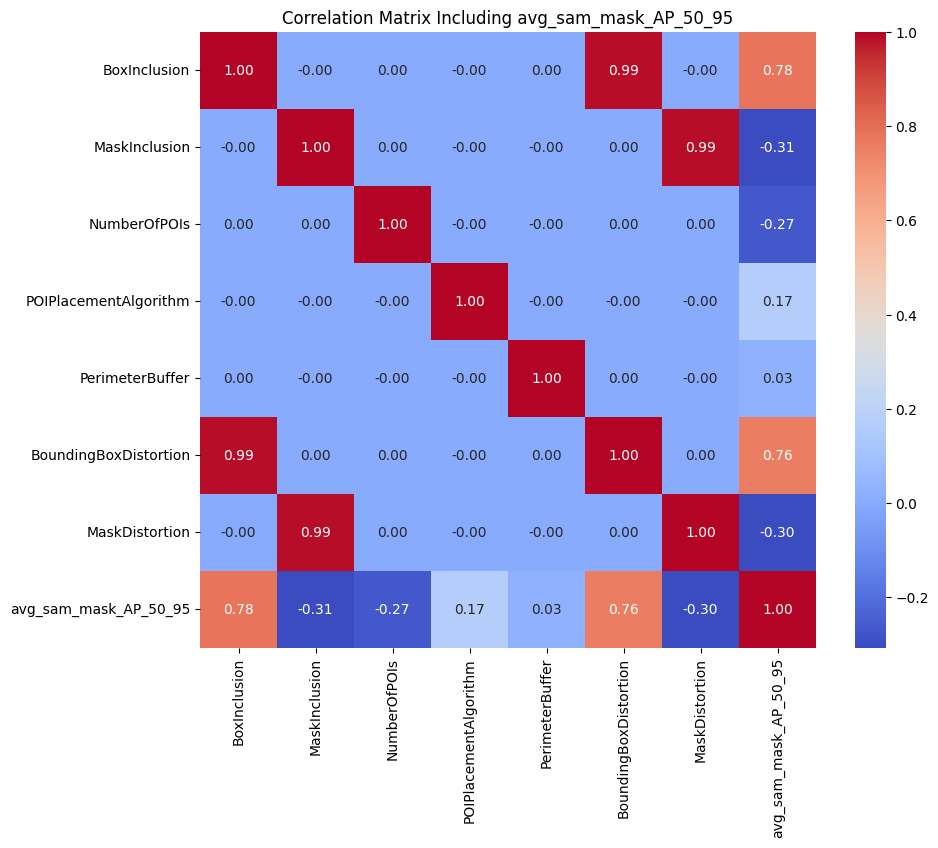

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

# Load the CSV file
file_path = "processedResults.csv"  # Update with the actual path if needed
data = pd.read_csv(file_path)

# Preview unique values in the 'BoxInclusion' column
print(set(data['BoxInclusion']))

# Remove '%' and convert numeric columns to floats
data["PerimeterBuffer"] = data["PerimeterBuffer"].str.rstrip('%').astype(float) / 100
data["BoundingBoxDistortion"] = data["BoundingBoxDistortion"].str.rstrip('%').astype(float) / 100
data["MaskDistortion"] = data["MaskDistortion"].str.rstrip('%').astype(float) / 100
data = data.replace(np.nan, 0)

# Select parameters
params = data[["BoxInclusion","MaskInclusion","NumberOfPOIs","POIPlacementAlgorithm","PerimeterBuffer","BoundingBoxDistortion","MaskDistortion"]].copy()
target = data["avg_sam_mask_AP_50_95"]

# Encode categorical variables
encoder = LabelEncoder()
params["POIPlacementAlgorithm"] = encoder.fit_transform(params["POIPlacementAlgorithm"])

# Add `avg_sam_mask_AP_50_95` to the parameters DataFrame for correlation calculation
corr_data = params
corr_data["avg_sam_mask_AP_50_95"] = target

# Calculate correlation matrix
corr_matrix = corr_data.corr()

# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True, fmt=".2f")
plt.title('Correlation Matrix Including avg_sam_mask_AP_50_95')
plt.show()


Descriptive Statistics for AP50-95:
Mean: 0.5291
Min: 0.0089
Max: 0.7794
90th Percentile: 0.6960
50th Percentile (Median): 0.5999


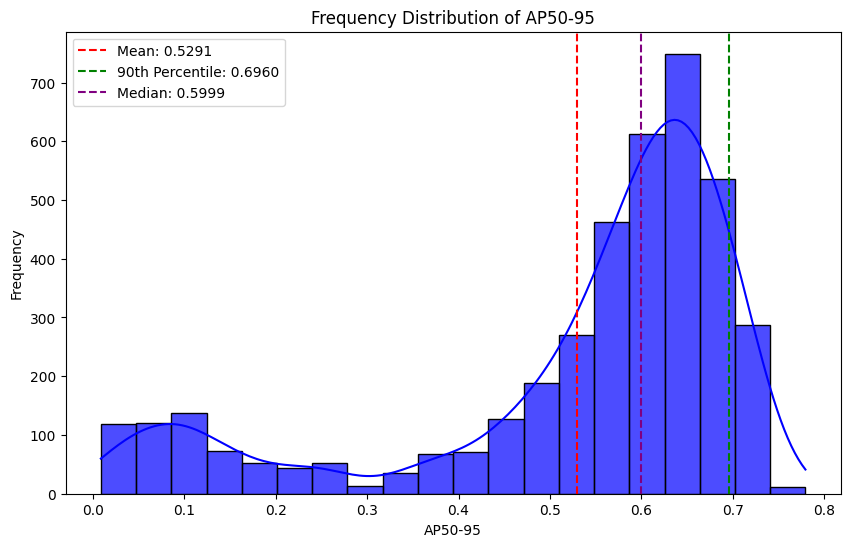

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
file_path = "processedResults.csv"  # Update with the actual path if needed
data = pd.read_csv(file_path)

# Extract the mean_IOU column
ap5095 = data["avg_sam_mask_AP_50_95"]

# Calculate descriptive statistics
mean_value = ap5095.mean()
min_value = ap5095.min()
max_value = ap5095.max()
percentile_90 = ap5095.quantile(0.9)
percentile_50 = ap5095.median()

# Print statistics
print("Descriptive Statistics for AP50-95:")
print(f"Mean: {mean_value:.4f}")
print(f"Min: {min_value:.4f}")
print(f"Max: {max_value:.4f}")
print(f"90th Percentile: {percentile_90:.4f}")
print(f"50th Percentile (Median): {percentile_50:.4f}")

# Plot the frequency distribution of mean_IOU
plt.figure(figsize=(10, 6))
sns.histplot(ap5095, kde=True, bins=20, color="blue", alpha=0.7)
plt.axvline(mean_value, color="red", linestyle="--", label=f"Mean: {mean_value:.4f}")
plt.axvline(percentile_90, color="green", linestyle="--", label=f"90th Percentile: {percentile_90:.4f}")
plt.axvline(percentile_50, color="purple", linestyle="--", label=f"Median: {percentile_50:.4f}")
plt.title("Frequency Distribution of AP50-95")
plt.xlabel("AP50-95")
plt.ylabel("Frequency")
plt.legend()
plt.show()


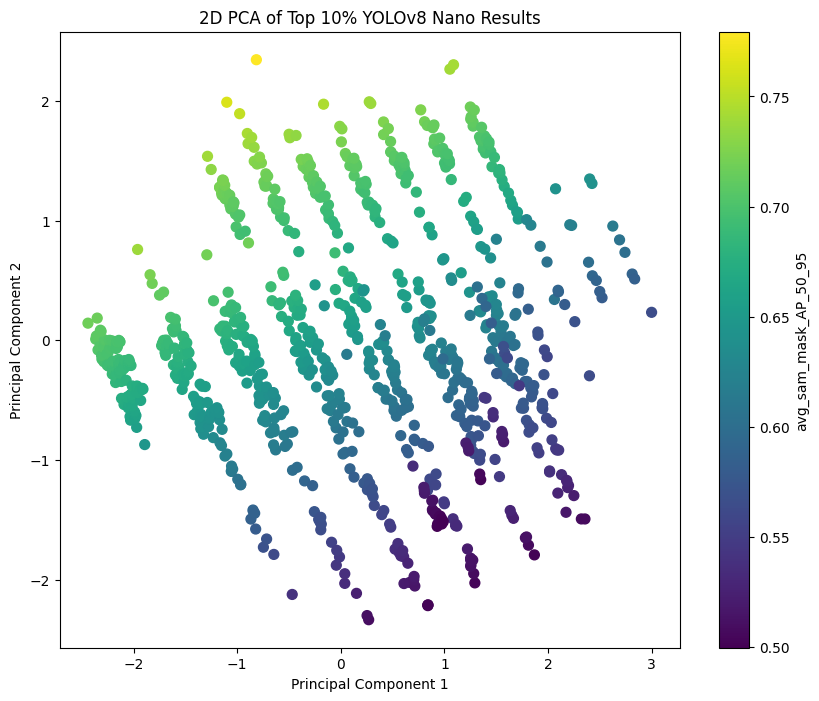

In [17]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Step 1: Filter the data for YOLOv8 Nano
file_path = "processedResults.csv"  # Update with the actual path if needed
data = pd.read_csv(file_path)
ap5095 = data["avg_sam_mask_AP_50_95"]

filtered_data = data[data['Model'] == 'YOLOv8 Nano']  # Adjust 'Model' column name if necessary

# Step 2: Filter for the top 10% based on avg_sam_mask_AP_50_95
top_10_percent_threshold = filtered_data["avg_sam_mask_AP_50_95"].quantile(0.25)
top_10_data = filtered_data[filtered_data["avg_sam_mask_AP_50_95"] >= top_10_percent_threshold]

# Step 3: Select numeric columns for PCA
numeric_features = top_10_data.select_dtypes(include=[np.number])

# Step 4: Standardize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(numeric_features)

# Step 5: Apply PCA to reduce dimensions to 2D
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

# Step 6: Create a DataFrame with PCA results
pca_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
pca_df['avg_sam_mask_AP_50_95'] = top_10_data["avg_sam_mask_AP_50_95"].values

# Step 7: Plot the PCA results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_df['PCA1'], pca_df['PCA2'], 
                       c=pca_df['avg_sam_mask_AP_50_95'], cmap='viridis', s=50)
plt.colorbar(scatter, label='avg_sam_mask_AP_50_95')
plt.title('2D PCA of Top 10% YOLOv8 Nano Results')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


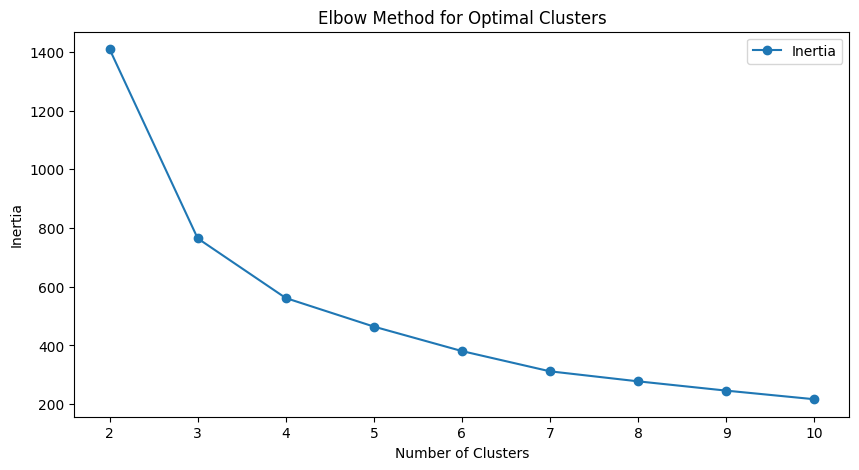

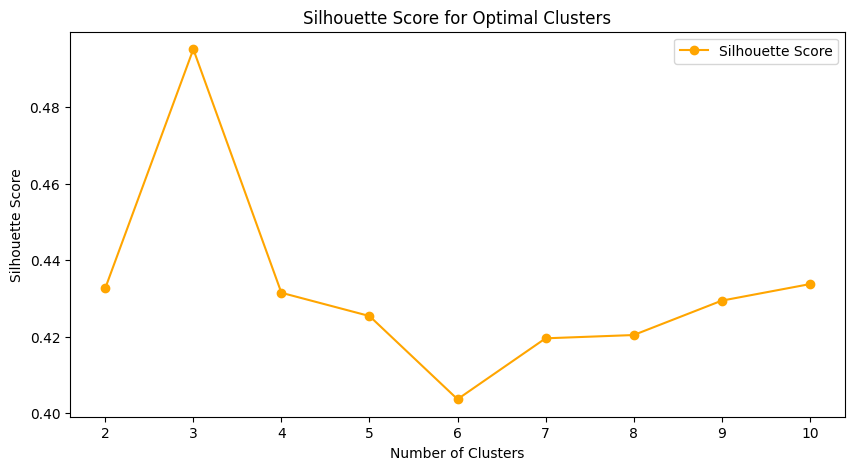

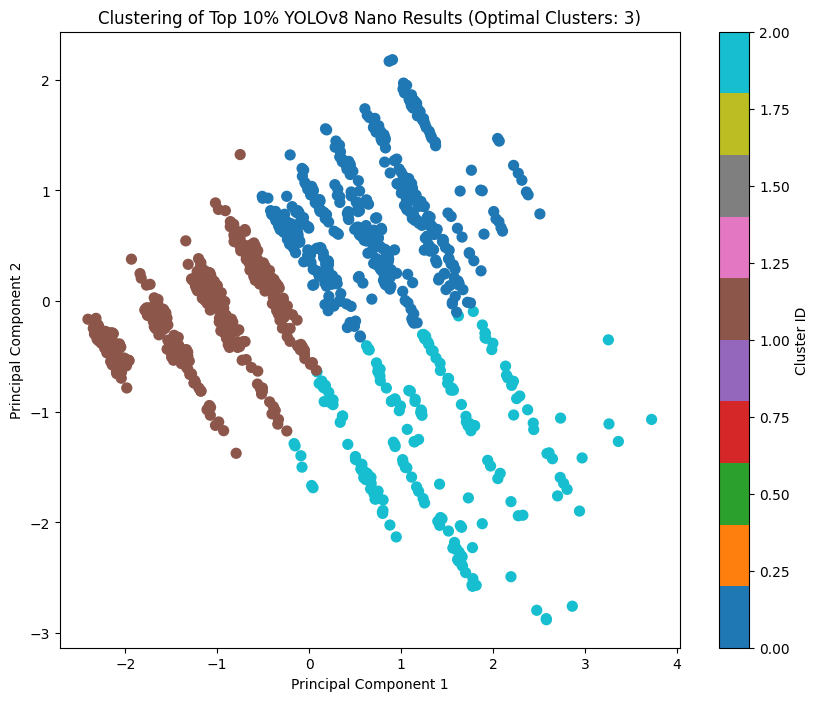

       PCA1      PCA2  avg_sam_mask_AP_50_95  Cluster
0 -2.306854 -0.343267               0.697747        1
1 -2.335417 -0.296645               0.703000        1
2 -2.301970 -0.344443               0.697505        1
3 -2.291294 -0.357567               0.695957        1
4 -2.093501 -0.655603               0.661974        1


In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Step 1: Determine the optimal number of clusters using the Elbow Method and Silhouette Score
def find_optimal_clusters(data, max_k=10):
    inertia = []
    silhouette_scores = []
    for k in range(2, max_k + 1):  # Start from 2 clusters
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(data)
        inertia.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(data, kmeans.labels_))
    
    return inertia, silhouette_scores

# Prepare the PCA-transformed data for clustering
pca_data = pca_df[['PCA1', 'PCA2']].values

# Calculate inertia and silhouette scores for 2 to 10 clusters
max_clusters = 10
inertia, silhouette_scores = find_optimal_clusters(pca_data, max_k=max_clusters)

# Plot the Elbow Method (Inertia)
plt.figure(figsize=(10, 5))
plt.plot(range(2, max_clusters + 1), inertia, marker='o', label='Inertia')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.legend()
plt.show()

# Plot the Silhouette Score
plt.figure(figsize=(10, 5))
plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o', color='orange', label='Silhouette Score')
plt.title('Silhouette Score for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.legend()
plt.show()

# Step 2: Perform KMeans clustering with the optimal number of clusters
optimal_clusters = silhouette_scores.index(max(silhouette_scores)) + 2  # Adding 2 because the range starts at 2
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
pca_df['Cluster'] = kmeans.fit_predict(pca_data)

# Step 3: Visualize the Clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_df['PCA1'], pca_df['PCA2'], 
                       c=pca_df['Cluster'], cmap='tab10', s=50, label='Clusters')
plt.colorbar(scatter, label='Cluster ID')
plt.title(f'Clustering of Top 10% YOLOv8 Nano Results (Optimal Clusters: {optimal_clusters})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Display the clustered data
print(pca_df.head())




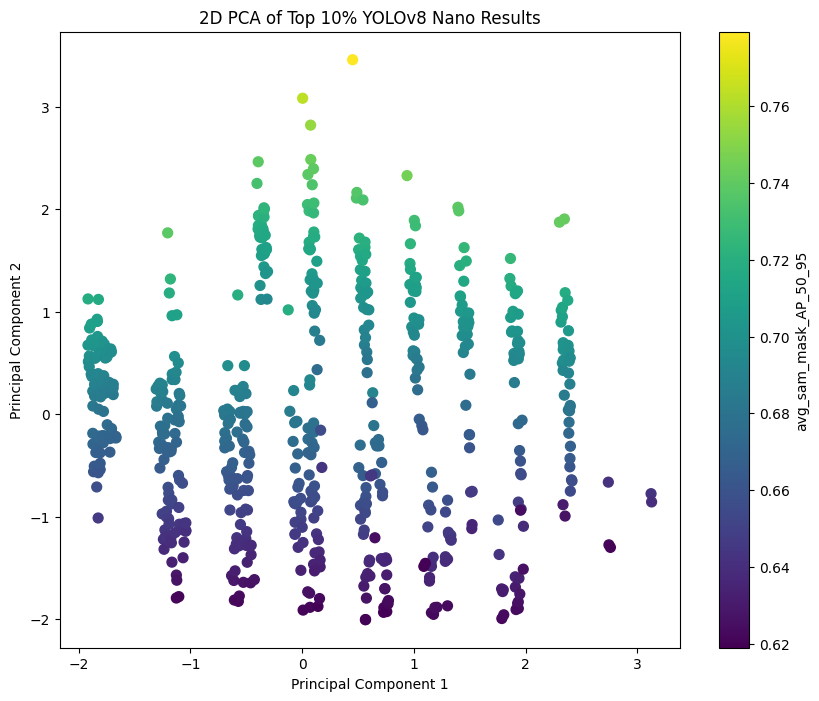

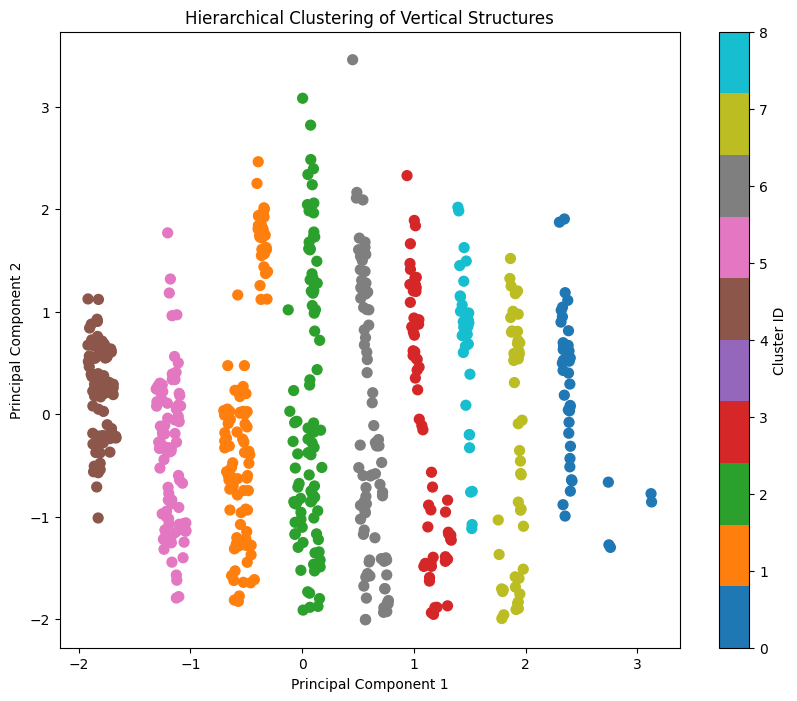

In [25]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Step 1: Filter the data for YOLOv8 Nano
file_path = "processedResults.csv"  # Update with the actual path if needed
data = pd.read_csv(file_path)
ap5095 = data["avg_sam_mask_AP_50_95"]

filtered_data = data[data['Model'] == 'YOLOv8 Nano']  # Adjust 'Model' column name if necessary

# Step 2: Filter for the top 10% based on avg_sam_mask_AP_50_95
top_10_percent_threshold = filtered_data["avg_sam_mask_AP_50_95"].quantile(0.50)
top_10_data = filtered_data[filtered_data["avg_sam_mask_AP_50_95"] >= top_10_percent_threshold]

# Step 3: Select numeric columns for PCA
numeric_features = top_10_data.select_dtypes(include=[np.number])

# Step 4: Standardize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(numeric_features)

# Step 5: Apply PCA to reduce dimensions to 2D
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

# Step 6: Create a DataFrame with PCA results
pca_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
pca_df['avg_sam_mask_AP_50_95'] = top_10_data["avg_sam_mask_AP_50_95"].values

# Step 7: Plot the PCA results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_df['PCA1'], pca_df['PCA2'], 
                       c=pca_df['avg_sam_mask_AP_50_95'], cmap='viridis', s=50)
plt.colorbar(scatter, label='avg_sam_mask_AP_50_95')
plt.title('2D PCA of Top 10% YOLOv8 Nano Results')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


from sklearn.cluster import AgglomerativeClustering

# Use only the first PCA component for clustering
pca_df['Cluster_Hierarchical'] = AgglomerativeClustering(n_clusters=9, 
                                                          linkage='ward').fit_predict(pca_df[['PCA1']])

# Visualize the result
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    pca_df['PCA1'], 
    pca_df['PCA2'], 
    c=pca_df['Cluster_Hierarchical'], 
    cmap='tab10', 
    s=50
)
plt.colorbar(scatter, label='Cluster ID')
plt.title('Hierarchical Clustering of Vertical Structures')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


/var/folders/ps/q4h47zmj6tl1vpklrcy_wr340000gq/T/ipykernel_1274/412656189.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data[col] = filtered_data[col].astype(str).str.rstrip('%').astype(float) / 100  # Convert %
/var/folders/ps/q4h47zmj6tl1vpklrcy_wr340000gq/T/ipykernel_1274/412656189.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data[col] = filtered_data[col].astype(str).str.rstrip('%').astype(float) / 100  # Convert %
/var/folders/ps/q4h47zmj6tl1vpklrcy_wr340000gq/T/ipykern

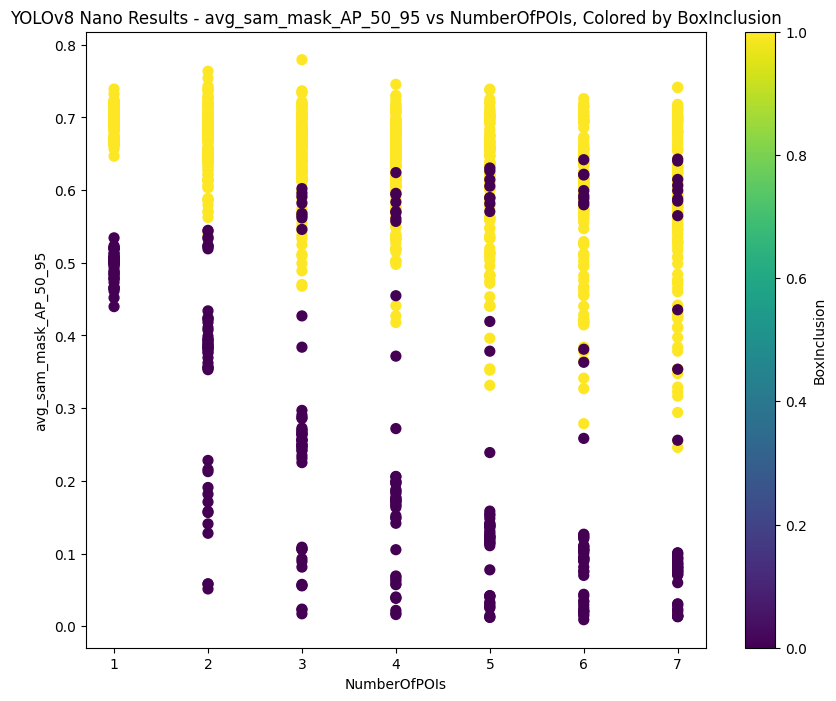

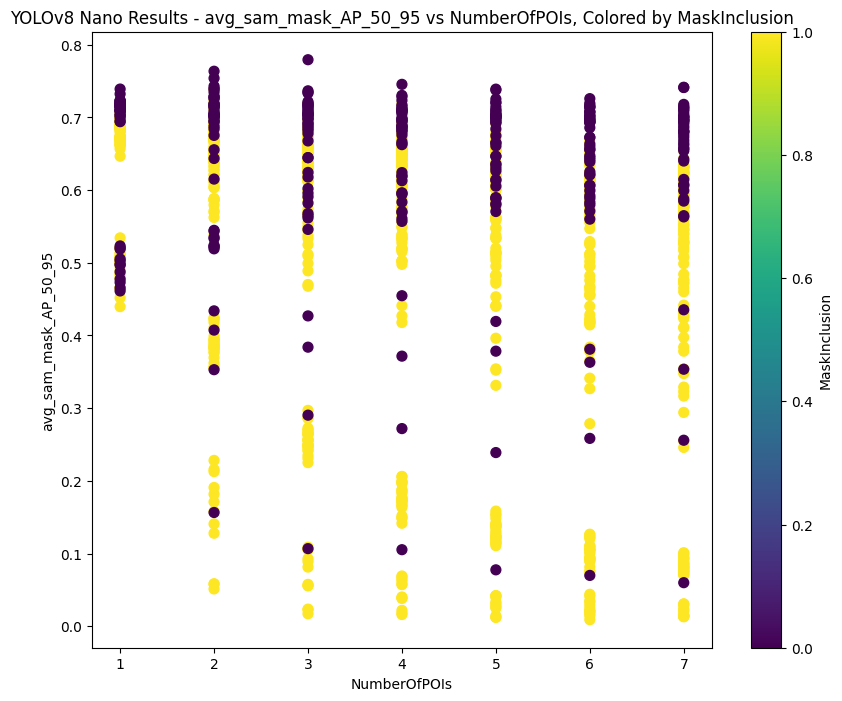

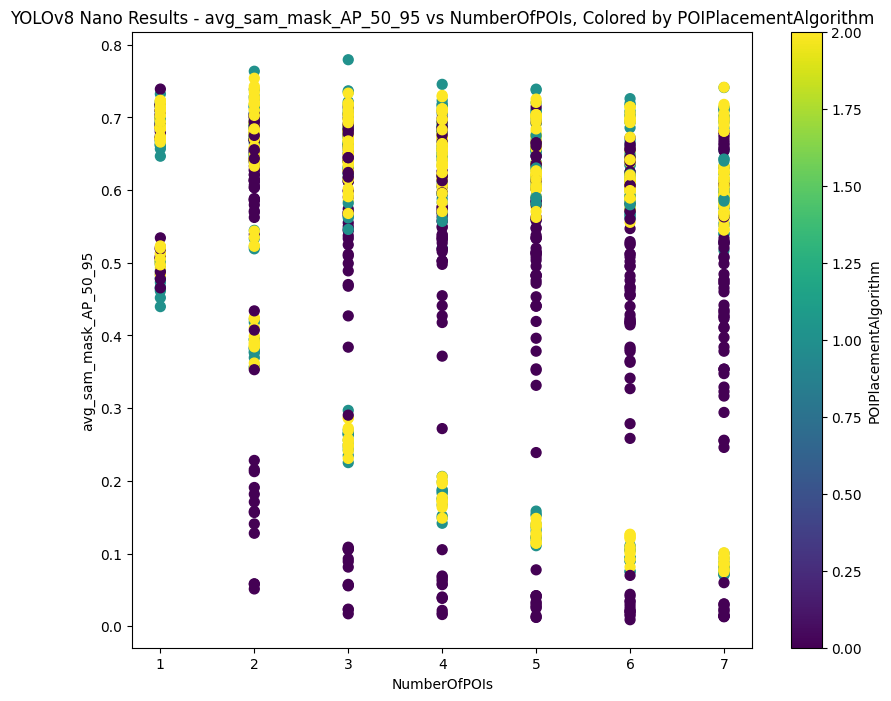

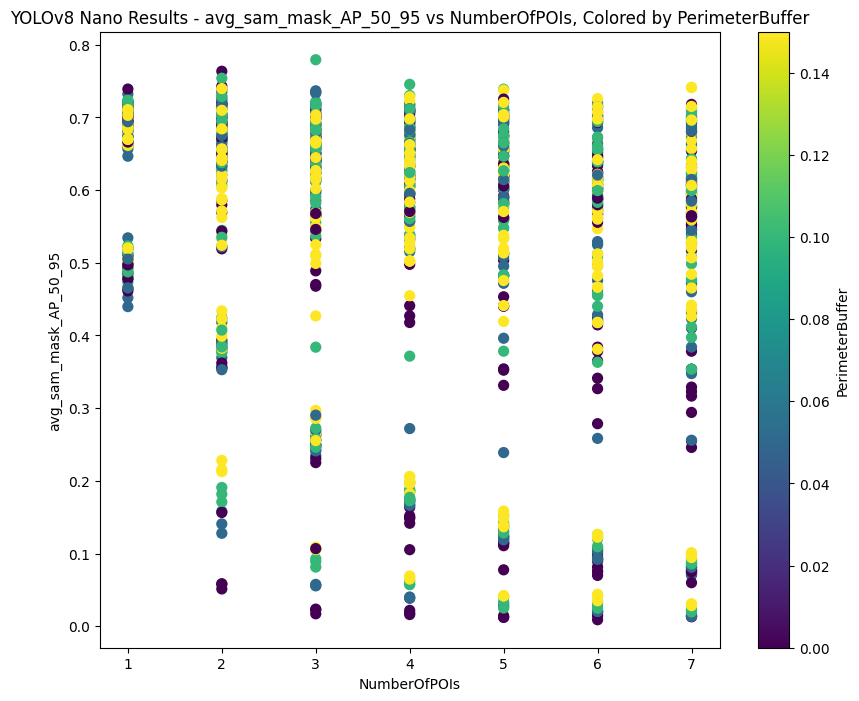

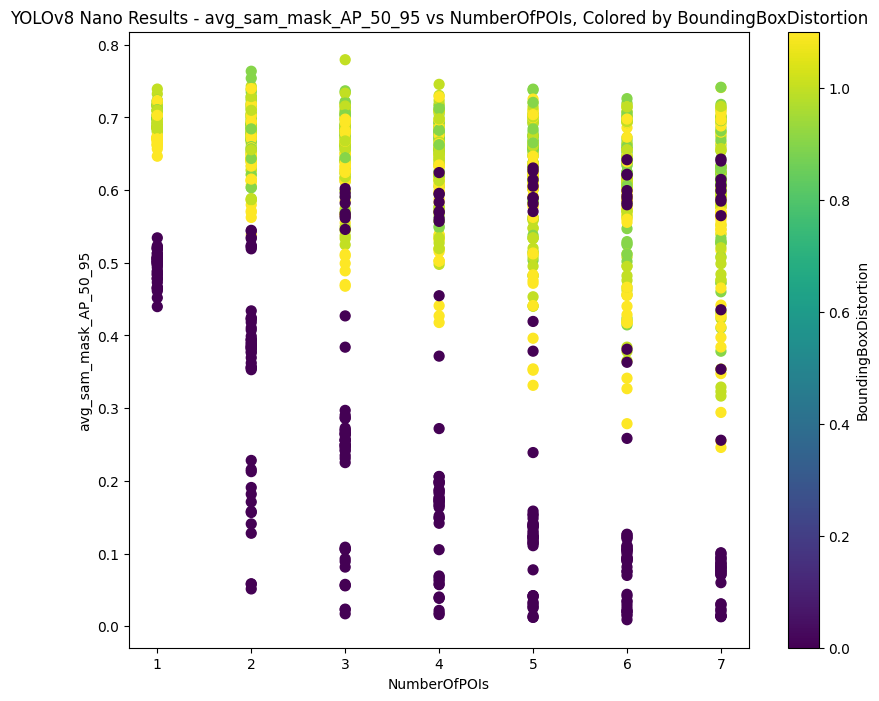

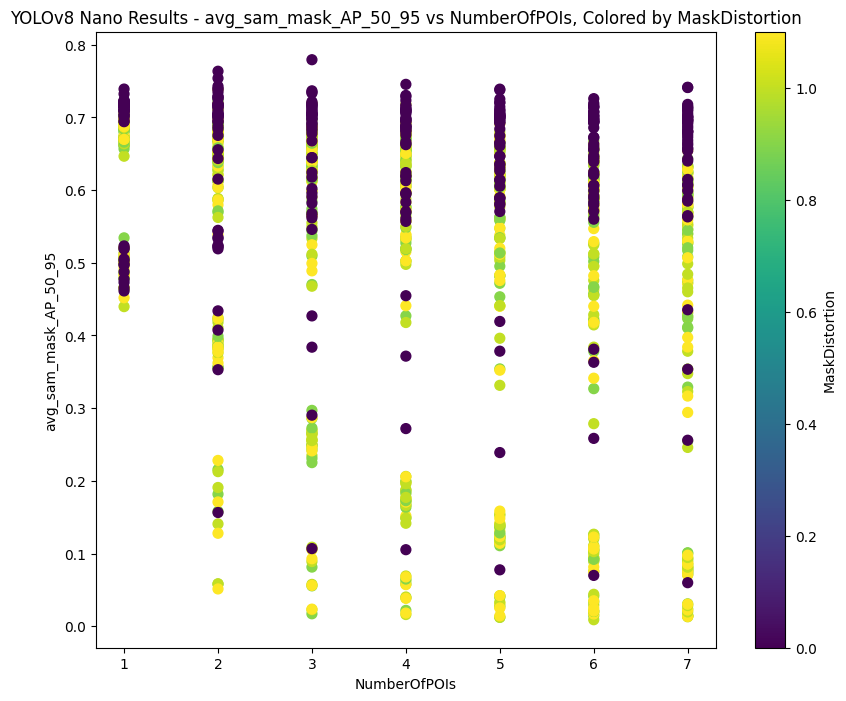

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Load data
file_path = "processedResults.csv"  # Update with the actual path if needed
data = pd.read_csv(file_path)
data = data.replace(np.nan, 0).drop(columns=['ID'])

# Filter for YOLOv8 Nano
filtered_data = data[data['Model'] == 'YOLOv8 Nano']

# Select relevant columns
x_col = "NumberOfPOIs"  # X-axis
y_col = "avg_sam_mask_AP_50_95"  # Y-axis

# Convert percentage columns to float
for col in ["PerimeterBuffer", "BoundingBoxDistortion", "MaskDistortion"]:
    filtered_data[col] = filtered_data[col].astype(str).str.rstrip('%').astype(float) / 100  # Convert %

# Encode categorical variables
categorical_cols = ["BoxInclusion", "MaskInclusion", "POIPlacementAlgorithm"]
encoder = LabelEncoder()
for col in categorical_cols:
    filtered_data[col] = encoder.fit_transform(filtered_data[col].astype(str))  # Convert categorical to numeric

# Get numeric columns for coloring
numeric_features = filtered_data.select_dtypes(include=[np.number]).drop(columns=[x_col, y_col])

# Generate scatter plots
for column in numeric_features.columns:
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(filtered_data[x_col], filtered_data[y_col], c=filtered_data[column], cmap='viridis', s=50)
    plt.colorbar(scatter, label=column)
    plt.title(f'YOLOv8 Nano Results - {y_col} vs {x_col}, Colored by {column}')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.show()


/var/folders/ps/q4h47zmj6tl1vpklrcy_wr340000gq/T/ipykernel_1274/1403425754.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["Category"] = filtered_data.apply(
/var/folders/ps/q4h47zmj6tl1vpklrcy_wr340000gq/T/ipykernel_1274/1403425754.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Category", y="avg_sam_mask_AP_50_95", data=filtered_data, palette="Set2", inner="quartile",


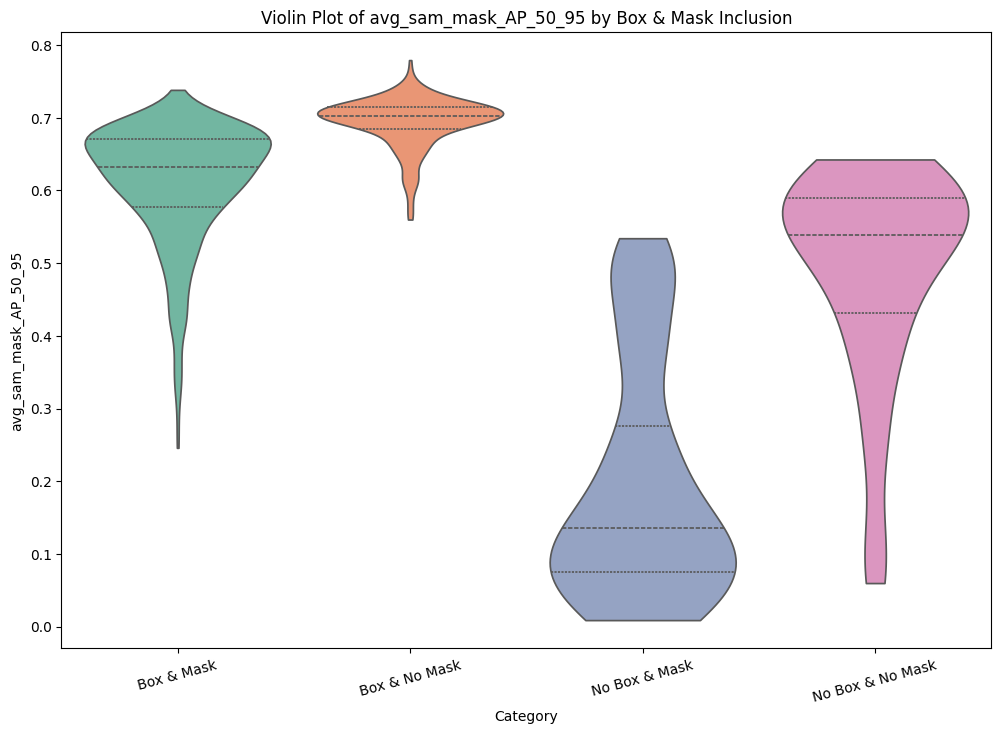

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

file_path = "processedResults.csv"  # Update with the actual path if needed
data = pd.read_csv(file_path)

# Filter for YOLOv8 Nano
filtered_data = data[data['Model'] == 'YOLOv8 Nano']
# filtered_data = data

# Ensure no negative values in avg_sam_mask_AP_50_95
# filtered_data["avg_sam_mask_AP_50_95"] = filtered_data["avg_sam_mask_AP_50_95"].clip(lower=0.0)

# Define categories
filtered_data["Category"] = filtered_data.apply(
    lambda row: "Box & Mask" if row["BoxInclusion"] and row["MaskInclusion"] else
                "Box & No Mask" if row["BoxInclusion"] and not row["MaskInclusion"] else
                "No Box & Mask" if not row["BoxInclusion"] and row["MaskInclusion"] else
                "No Box & No Mask", axis=1
)

# Create violin plot
plt.figure(figsize=(12, 8))
sns.violinplot(x="Category", y="avg_sam_mask_AP_50_95", data=filtered_data, palette="Set2", inner="quartile",
                                                        cut=0)#, bw_adjust=0.5)

# Customize labels
plt.title("Violin Plot of avg_sam_mask_AP_50_95 by Box & Mask Inclusion")
plt.xlabel("Category")
plt.ylabel("avg_sam_mask_AP_50_95")
plt.xticks(rotation=15)

plt.show()


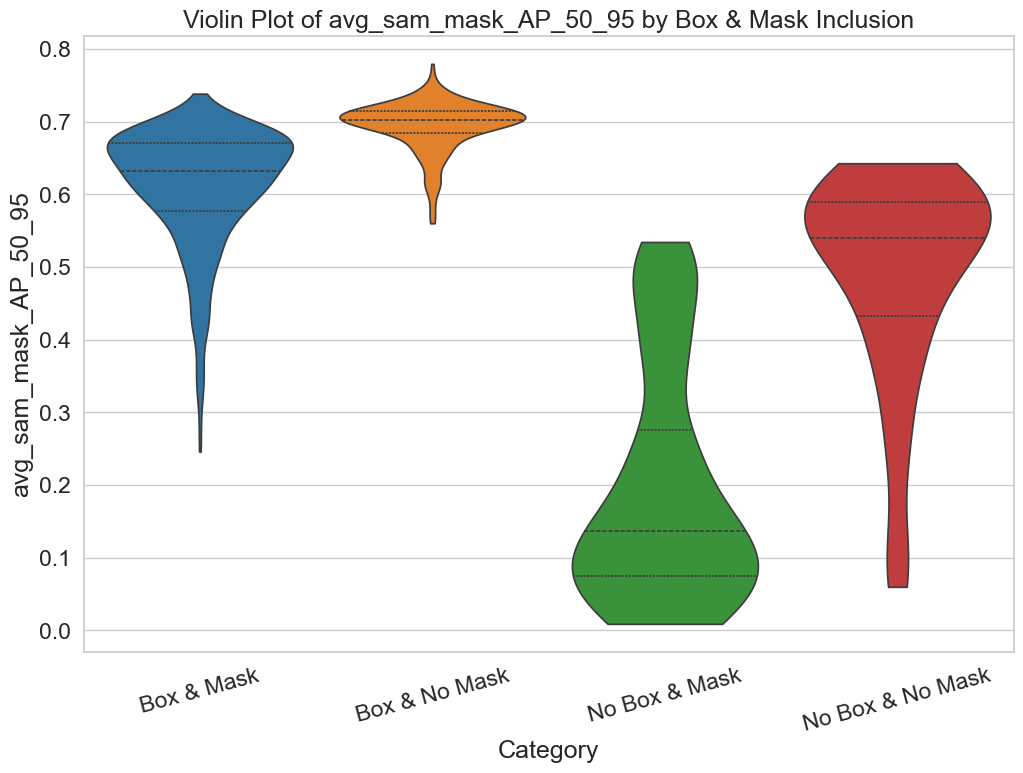

In [97]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

file_path = "processedResults.csv"  # Update with the actual path if needed
data = pd.read_csv(file_path)

# Filter for YOLOv8 Nano
filtered_data = data[data['Model'] == 'YOLOv8 Nano']

# Define categories
filtered_data["Category"] = filtered_data.apply(
    lambda row: "Box & Mask" if row["BoxInclusion"] and row["MaskInclusion"] else
                "Box & No Mask" if row["BoxInclusion"] and not row["MaskInclusion"] else
                "No Box & Mask" if not row["BoxInclusion"] and row["MaskInclusion"] else
                "No Box & No Mask", axis=1
)

# Define custom color palette
custom_palette = {
    "Box & Mask": "#1f77b4",  # Deep Blue
    "Box & No Mask": "#ff7f0e",  # Dark Orange
    "No Box & Mask": "#2ca02c",  # Forest Green
    "No Box & No Mask": "#d62728"  # Crimson Red
}

# Create violin plot
plt.figure(figsize=(12, 8))
sns.violinplot(x="Category", y="avg_sam_mask_AP_50_95", data=filtered_data, 
               palette=custom_palette, inner="quartile", cut=0)

# Customize labels
plt.title("Violin Plot of avg_sam_mask_AP_50_95 by Box & Mask Inclusion")
plt.xlabel("Category")
plt.ylabel("avg_sam_mask_AP_50_95")
plt.xticks(rotation=15)

plt.show()


/var/folders/ps/q4h47zmj6tl1vpklrcy_wr340000gq/T/ipykernel_1274/2142364329.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["avg_sam_mask_AP_50_95"] = filtered_data["avg_sam_mask_AP_50_95"].clip(lower=0)
/var/folders/ps/q4h47zmj6tl1vpklrcy_wr340000gq/T/ipykernel_1274/2142364329.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["BoundingBoxDistortion"] = filtered_data["BoundingBoxDistortion"].astype(str).str.rstrip('%').astype(float) / 100  # Convert to decimal
/var/folders

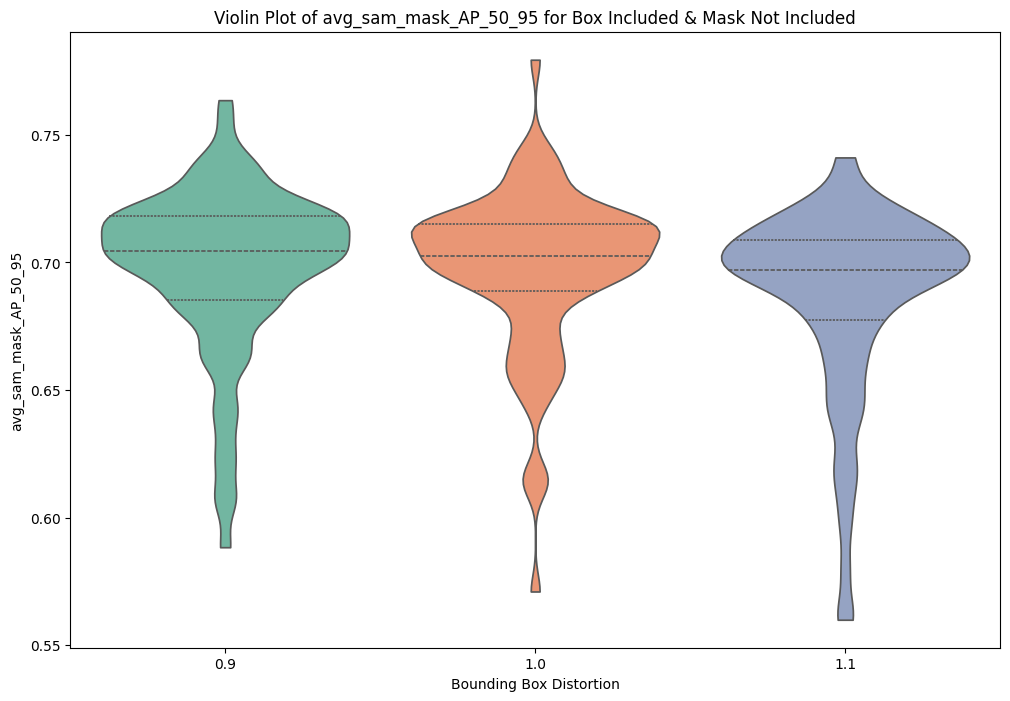

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt


file_path = "processedResults.csv"  # Update with the actual path if needed
data = pd.read_csv(file_path)

# Filter for YOLOv8 Nano
filtered_data = data[data['Model'] == 'YOLOv8 Nano']
# Ensure no negative values in avg_sam_mask_AP_50_95
filtered_data["avg_sam_mask_AP_50_95"] = filtered_data["avg_sam_mask_AP_50_95"].clip(lower=0)

# Convert BoundingBoxDistortion to numeric (if not already)
filtered_data["BoundingBoxDistortion"] = filtered_data["BoundingBoxDistortion"].astype(str).str.rstrip('%').astype(float) / 100  # Convert to decimal

# Filter for BoxInclusion = True & MaskInclusion = False
filtered_subset = filtered_data[(filtered_data["BoxInclusion"] == True) & (filtered_data["MaskInclusion"] == False)]

# Keep only BoundingBoxDistortion values of 90%, 100%, and 110%
filtered_subset = filtered_subset[filtered_subset["BoundingBoxDistortion"].isin([0.90, 1.00, 1.10])]

# Create violin plot
plt.figure(figsize=(12, 8))
sns.violinplot(x="BoundingBoxDistortion", y="avg_sam_mask_AP_50_95", data=filtered_subset, 
               palette="Set2", inner="quartile", cut=0, bw_adjust=0.5)  # Fix KDE smoothing

# Customize labels
plt.title("Violin Plot of avg_sam_mask_AP_50_95 for Box Included & Mask Not Included")
plt.xlabel("Bounding Box Distortion")
plt.ylabel("avg_sam_mask_AP_50_95")

plt.show()


/var/folders/ps/q4h47zmj6tl1vpklrcy_wr340000gq/T/ipykernel_1274/4017353380.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["avg_sam_mask_AP_50_95"] = filtered_data["avg_sam_mask_AP_50_95"].clip(lower=0)
/var/folders/ps/q4h47zmj6tl1vpklrcy_wr340000gq/T/ipykernel_1274/4017353380.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["BoundingBoxDistortion"] = filtered_data["BoundingBoxDistortion"].astype(str).str.rstrip('%').astype(float) / 100  # Convert to decimal
/var/folders

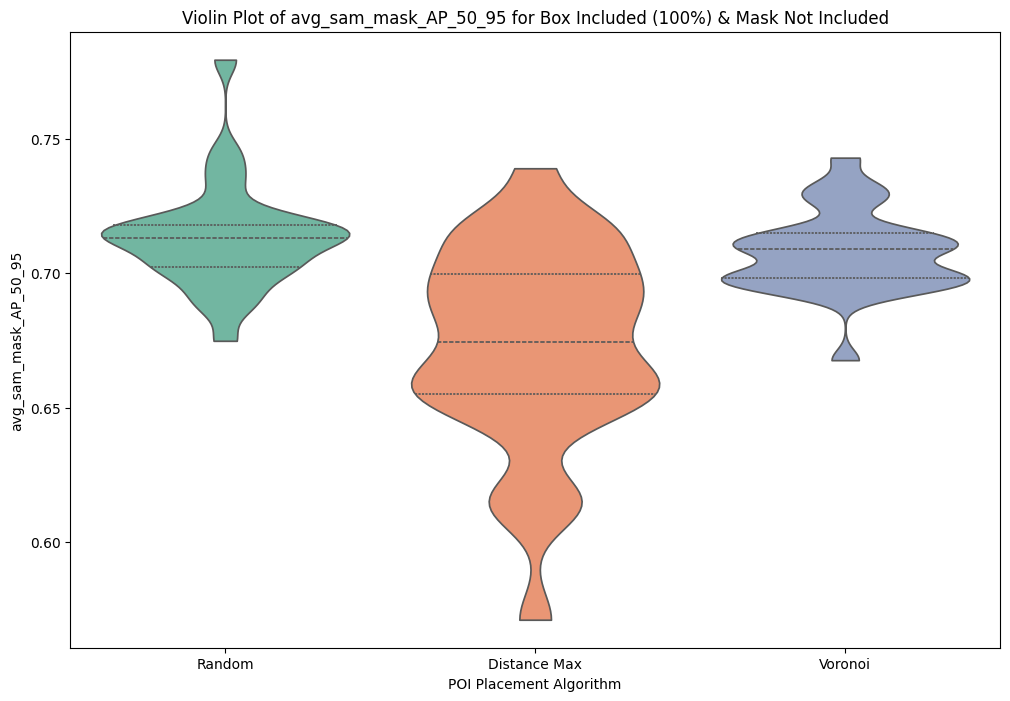

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt


file_path = "processedResults.csv"  # Update with the actual path if needed
data = pd.read_csv(file_path)

# Filter for YOLOv8 Nano
filtered_data = data[data['Model'] == 'YOLOv8 Nano']
# Ensure no negative values in avg_sam_mask_AP_50_95
filtered_data["avg_sam_mask_AP_50_95"] = filtered_data["avg_sam_mask_AP_50_95"].clip(lower=0)

# Convert BoundingBoxDistortion to numeric (if not already)
filtered_data["BoundingBoxDistortion"] = filtered_data["BoundingBoxDistortion"].astype(str).str.rstrip('%').astype(float) / 100  # Convert to decimal

# Filter for BoxInclusion = True, MaskInclusion = False, and BoundingBoxDistortion = 100%
filtered_subset = filtered_data[
    (filtered_data["BoxInclusion"] == True) & 
    (filtered_data["MaskInclusion"] == False) & 
    (filtered_data["BoundingBoxDistortion"] == 1.00)
]

# Create violin plot
plt.figure(figsize=(12, 8))
sns.violinplot(x="POIPlacementAlgorithm", y="avg_sam_mask_AP_50_95", data=filtered_subset, 
               palette="Set2", inner="quartile", cut=0, bw_adjust=0.5)  # Fix KDE smoothing

# Customize labels
plt.title("Violin Plot of avg_sam_mask_AP_50_95 for Box Included (100%) & Mask Not Included")
plt.xlabel("POI Placement Algorithm")
plt.ylabel("avg_sam_mask_AP_50_95")

plt.show()


/var/folders/ps/q4h47zmj6tl1vpklrcy_wr340000gq/T/ipykernel_1274/3706207245.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["avg_sam_mask_AP_50_95"] = filtered_data["avg_sam_mask_AP_50_95"].clip(lower=0)
/var/folders/ps/q4h47zmj6tl1vpklrcy_wr340000gq/T/ipykernel_1274/3706207245.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["BoundingBoxDistortion"] = filtered_data["BoundingBoxDistortion"].astype(str).str.rstrip('%').astype(float) / 100
/var/folders/ps/q4h47zmj6tl1vpklrc

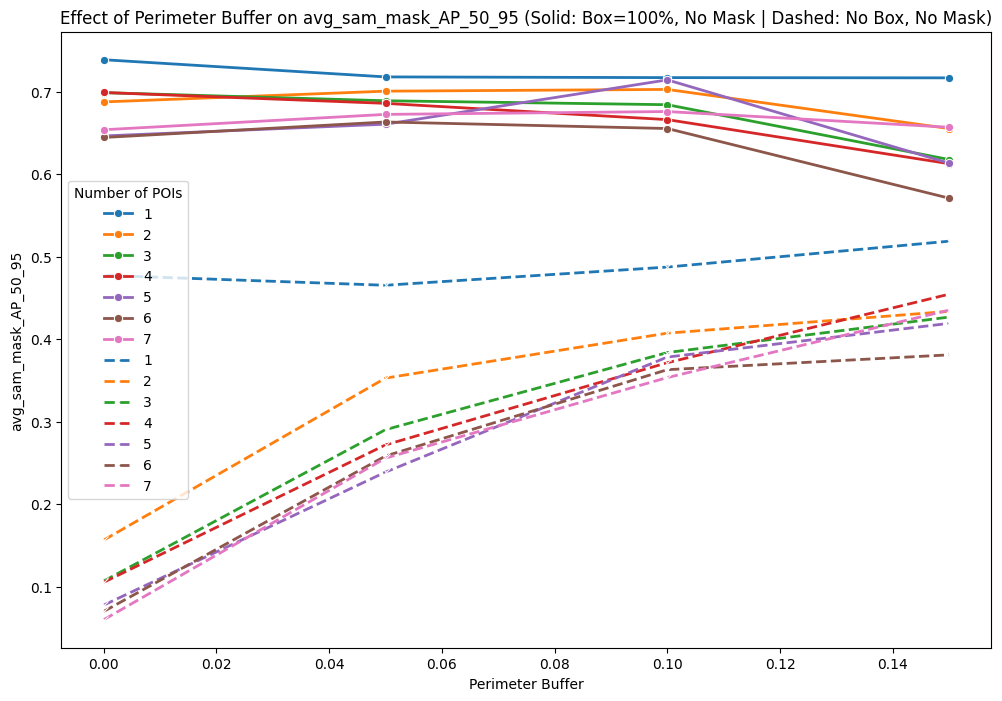

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
file_path = "processedResults.csv"  # Update with the actual path if needed
data = pd.read_csv(file_path)

# Filter for YOLOv8 Nano
filtered_data = data[data['Model'] == 'YOLOv8 Nano']

# Ensure no negative values in avg_sam_mask_AP_50_95
filtered_data["avg_sam_mask_AP_50_95"] = filtered_data["avg_sam_mask_AP_50_95"].clip(lower=0)

# Convert percentage columns to numeric
filtered_data["BoundingBoxDistortion"] = filtered_data["BoundingBoxDistortion"].astype(str).str.rstrip('%').astype(float) / 100
filtered_data["PerimeterBuffer"] = filtered_data["PerimeterBuffer"].astype(str).str.rstrip('%').astype(float) / 100

# Filter datasets
solid_lines = filtered_data[
    (filtered_data["BoxInclusion"] == True) & 
    (filtered_data["BoundingBoxDistortion"] == 1.00) & 
    (filtered_data["MaskInclusion"] == False) & 
    (filtered_data["POIPlacementAlgorithm"] == "Distance Max")
]

dashed_lines = filtered_data[
    (filtered_data["BoxInclusion"] == False) & 
    (filtered_data["MaskInclusion"] == False) & 
    (filtered_data["POIPlacementAlgorithm"] == "Distance Max")
]

# Create plot
plt.figure(figsize=(12, 8))

# Plot solid lines for Box = True at 100%
sns.lineplot(data=solid_lines, x="PerimeterBuffer", y="avg_sam_mask_AP_50_95", 
             hue="NumberOfPOIs", marker="o", palette="tab10", linewidth=2, ci=None, linestyle='solid')

# Plot dashed lines for Box = False
sns.lineplot(data=dashed_lines, x="PerimeterBuffer", y="avg_sam_mask_AP_50_95", 
             hue="NumberOfPOIs", marker="s", palette="tab10", linewidth=2, ci=None, linestyle='dashed')

# Customize labels
plt.title("Effect of Perimeter Buffer on avg_sam_mask_AP_50_95 (Solid: Box=100%, No Mask | Dashed: No Box, No Mask)")
plt.xlabel("Perimeter Buffer")
plt.ylabel("avg_sam_mask_AP_50_95")
plt.legend(title="Number of POIs")

plt.show()


/var/folders/ps/q4h47zmj6tl1vpklrcy_wr340000gq/T/ipykernel_1274/2568419220.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["avg_sam_mask_AP_50_95"] = filtered_data["avg_sam_mask_AP_50_95"].clip(lower=0)
/var/folders/ps/q4h47zmj6tl1vpklrcy_wr340000gq/T/ipykernel_1274/2568419220.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["BoundingBoxDistortion"] = filtered_data["BoundingBoxDistortion"].astype(str).str.rstrip('%').astype(float) / 100
/var/folders/ps/q4h47zmj6tl1vpklrc

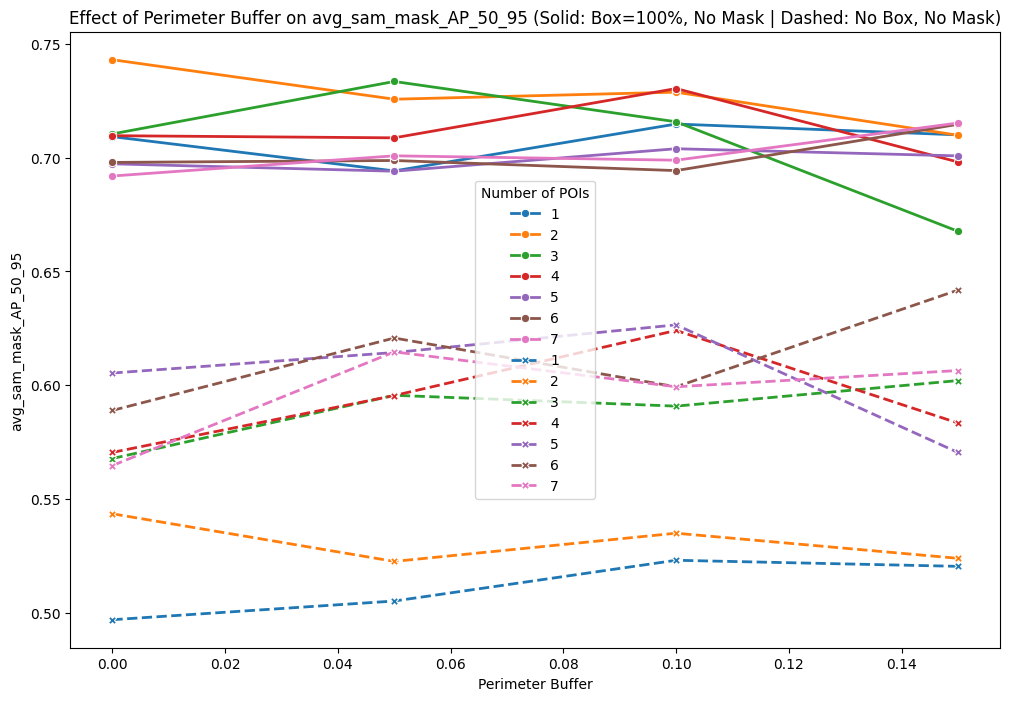

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
file_path = "processedResults.csv"  # Update with the actual path if needed
data = pd.read_csv(file_path)

# Filter for YOLOv8 Nano
filtered_data = data[data['Model'] == 'YOLOv8 Nano']

# Ensure no negative values in avg_sam_mask_AP_50_95
filtered_data["avg_sam_mask_AP_50_95"] = filtered_data["avg_sam_mask_AP_50_95"].clip(lower=0)

# Convert percentage columns to numeric
filtered_data["BoundingBoxDistortion"] = filtered_data["BoundingBoxDistortion"].astype(str).str.rstrip('%').astype(float) / 100
filtered_data["PerimeterBuffer"] = filtered_data["PerimeterBuffer"].astype(str).str.rstrip('%').astype(float) / 100

# Filter datasets
solid_lines = filtered_data[
    (filtered_data["BoxInclusion"] == True) & 
    (filtered_data["BoundingBoxDistortion"] == 1.00) & 
    (filtered_data["MaskInclusion"] == False) & 
    (filtered_data["POIPlacementAlgorithm"] == "Voronoi")
]

dashed_lines = filtered_data[
    (filtered_data["BoxInclusion"] == False) & 
    (filtered_data["MaskInclusion"] == False) & 
    (filtered_data["POIPlacementAlgorithm"] == "Voronoi")
]

# Create plot
plt.figure(figsize=(12, 8))

# Plot solid lines for Box = True at 100%
sns.lineplot(data=solid_lines, x="PerimeterBuffer", y="avg_sam_mask_AP_50_95", 
             hue="NumberOfPOIs", marker="o", palette="tab10", linewidth=2, ci=None, linestyle='solid')

# Plot dashed lines for Box = False
sns.lineplot(data=dashed_lines, x="PerimeterBuffer", y="avg_sam_mask_AP_50_95", 
             hue="NumberOfPOIs", marker="X", palette="tab10", linewidth=2, ci=None, linestyle='dashed')

# Customize labels
plt.title("Effect of Perimeter Buffer on avg_sam_mask_AP_50_95 (Solid: Box=100%, No Mask | Dashed: No Box, No Mask)")
plt.xlabel("Perimeter Buffer")
plt.ylabel("avg_sam_mask_AP_50_95")
plt.legend(title="Number of POIs")

plt.show()


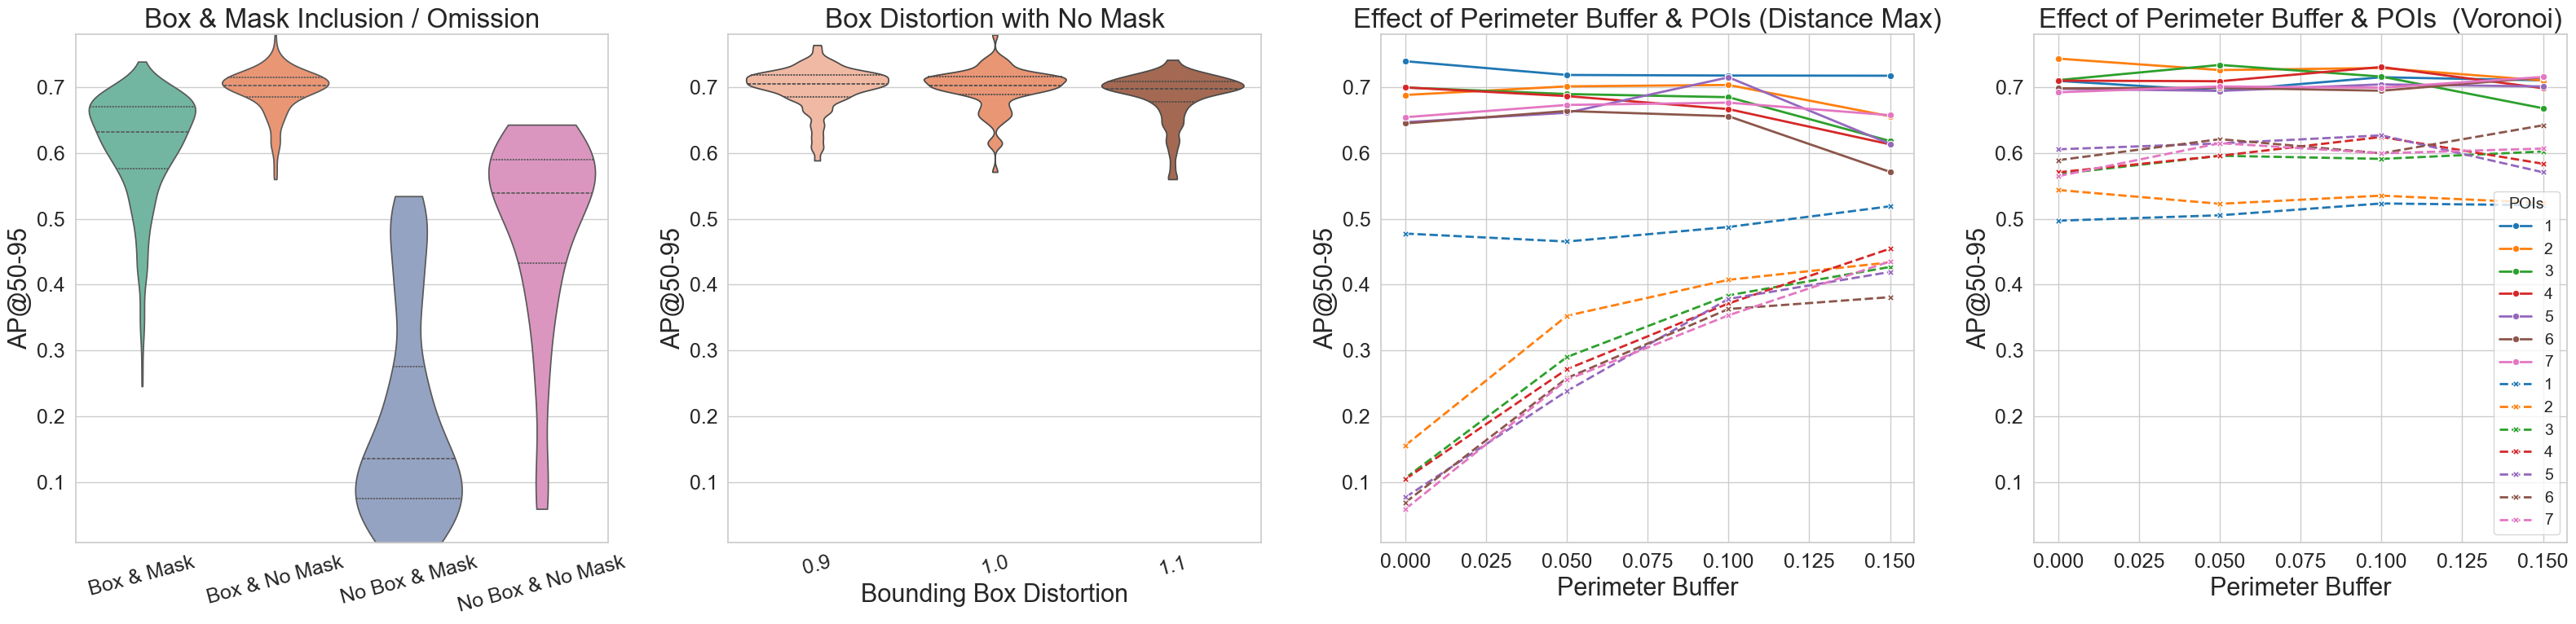

In [96]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Suppress specific warnings (optional)
import warnings
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Set global font size using seaborn's set_theme with a larger font_scale
sns.set_theme(style="whitegrid", font_scale=1.5)  # Adjust font_scale as needed

# Load data
file_path = "processedResults.csv"  # Update with the actual path if needed
data = pd.read_csv(file_path)

# Filter for YOLOv8 Nano and create a copy to avoid SettingWithCopyWarning
filtered_data = data[data['Model'] == 'YOLOv8 Nano'].copy()

# Ensure no negative values in avg_sam_mask_AP_50_95
filtered_data.loc[:, "avg_sam_mask_AP_50_95"] = filtered_data["avg_sam_mask_AP_50_95"].clip(lower=0)

# Convert percentage columns to numeric
filtered_data.loc[:, "BoundingBoxDistortion"] = (
    filtered_data["BoundingBoxDistortion"].astype(str).str.rstrip('%').astype(float) / 100
)
filtered_data.loc[:, "PerimeterBuffer"] = (
    filtered_data["PerimeterBuffer"].astype(str).str.rstrip('%').astype(float) / 100
)

# Define categories for the first plot
filtered_data.loc[:, "Category"] = filtered_data.apply(
    lambda row: "Box & Mask" if row["BoxInclusion"] and row["MaskInclusion"] else
                "Box & No Mask" if row["BoxInclusion"] and not row["MaskInclusion"] else
                "No Box & Mask" if not row["BoxInclusion"] and row["MaskInclusion"] else
                "No Box & No Mask", axis=1
)

# Prepare subsets for the second plot
filtered_subset1 = filtered_data[
    (filtered_data["BoxInclusion"] == True) & (filtered_data["MaskInclusion"] == False)
].copy()
filtered_subset1 = filtered_subset1[filtered_subset1["BoundingBoxDistortion"].isin([0.90, 1.00, 1.10])].copy()

# Prepare subsets for the third plot (Distance Max)
solid_lines_dm = filtered_data[
    (filtered_data["BoxInclusion"] == True) & 
    (filtered_data["BoundingBoxDistortion"] == 1.00) & 
    (filtered_data["MaskInclusion"] == False) & 
    (filtered_data["POIPlacementAlgorithm"] == "Distance Max")
].copy()

dashed_lines_dm = filtered_data[
    (filtered_data["BoxInclusion"] == False) & 
    (filtered_data["MaskInclusion"] == False) & 
    (filtered_data["POIPlacementAlgorithm"] == "Distance Max")
].copy()

# Prepare subsets for the fourth plot (Voronoi for consistency)
solid_lines_voronoi = filtered_data[
    (filtered_data["BoxInclusion"] == True) & 
    (filtered_data["BoundingBoxDistortion"] == 1.00) & 
    (filtered_data["MaskInclusion"] == False) & 
    (filtered_data["POIPlacementAlgorithm"] == "Voronoi")
].copy()

dashed_lines_voronoi = filtered_data[
    (filtered_data["BoxInclusion"] == False) & 
    (filtered_data["MaskInclusion"] == False) & 
    (filtered_data["POIPlacementAlgorithm"] == "Voronoi")
].copy()

# Calculate global min and max for avg_sam_mask_AP_50_95
all_data = pd.concat([
    filtered_data["avg_sam_mask_AP_50_95"], 
    filtered_subset1["avg_sam_mask_AP_50_95"], 
    solid_lines_dm["avg_sam_mask_AP_50_95"], 
    dashed_lines_dm["avg_sam_mask_AP_50_95"], 
    solid_lines_voronoi["avg_sam_mask_AP_50_95"], 
    dashed_lines_voronoi["avg_sam_mask_AP_50_95"]
])

global_min = all_data.min()
global_max = all_data.max()

# Define custom colors for the second plot
base_color = sns.color_palette("Set2")[1]  # Base color for second violin
lighter_color = mcolors.to_rgb(base_color)  # Convert to RGB
lighter_color = [(c + 0.5) / 1.5 for c in lighter_color]  # Lighten color
darker_color = [(c * 0.7) for c in mcolors.to_rgb(base_color)]  # Darken color

# Create a figure with 4 subplots
fig, axes = plt.subplots(1, 4, figsize=(32, 8))  # Increased figure size for better readability

# -------------------
# Plot 1: Violin plot for avg_sam_mask_AP_50_95 by Category
# -------------------
sns.violinplot(
    x="Category", 
    y="avg_sam_mask_AP_50_95", 
    data=filtered_data, 
    hue="Category",  # Assign hue to x variable to comply with FutureWarning
    palette="Set2",  # Apply different colors to each Category
    inner="quartile", 
    cut=0, 
    density_norm="width",  # Ensure equal area
    ax=axes[0],
    legend=False  # Disable legend to prevent duplication
)
axes[0].set_title("Box & Mask Inclusion / Omission", fontsize=24)
axes[0].set_xlabel("", fontsize=1)
axes[0].set_ylabel("AP@50-95", fontsize=22)
axes[0].tick_params(axis='x', rotation=15, labelsize=18)
axes[0].tick_params(axis='y', labelsize=18)
axes[0].set_ylim(global_min, global_max)

# -------------------
# Plot 2: Violin plot for BoundingBoxDistortion with custom colors
# -------------------
sns.violinplot(
    x="BoundingBoxDistortion", 
    y="avg_sam_mask_AP_50_95", 
    data=filtered_subset1, 
    hue="BoundingBoxDistortion",  # Assign hue to x variable to comply with FutureWarning
    palette=[lighter_color, base_color, darker_color], 
    inner="quartile", 
    cut=0, 
    bw_adjust=0.5, 
    density_norm="width",  # Ensure equal area
    ax=axes[1],
    legend=False  # Disable legend to prevent duplication
)
axes[1].set_title("Box Distortion with No Mask", fontsize=24)
axes[1].set_xlabel("Bounding Box Distortion", fontsize=22)
axes[1].set_ylabel("AP@50-95", fontsize=22)
axes[1].tick_params(axis='x', rotation=15, labelsize=18)
axes[1].tick_params(axis='y', labelsize=18)
axes[1].set_ylim(global_min, global_max)

# -------------------
# Plot 3: Line plot for Distance Max (Solid and Dashed Lines)
# -------------------
sns.lineplot(
    data=solid_lines_dm, 
    x="PerimeterBuffer", 
    y="avg_sam_mask_AP_50_95", 
    hue="NumberOfPOIs", 
    marker="o", 
    palette="tab10", 
    linewidth=2, 
    errorbar=None,  # Updated from ci=None
    linestyle='solid', 
    ax=axes[2]
)
sns.lineplot(
    data=dashed_lines_dm, 
    x="PerimeterBuffer", 
    y="avg_sam_mask_AP_50_95", 
    hue="NumberOfPOIs", 
    marker="X", 
    palette="tab10", 
    linewidth=2, 
    errorbar=None,  # Updated from ci=None
    linestyle='dashed', 
    ax=axes[2]
)
axes[2].set_title("Effect of Perimeter Buffer & POIs (Distance Max)", fontsize=24)
axes[2].set_xlabel("Perimeter Buffer", fontsize=22)
axes[2].set_ylabel("AP@50-95", fontsize=22)
axes[2].tick_params(axis='x', labelsize=18)
axes[2].tick_params(axis='y', labelsize=18)
# axes[2].legend(title="Number of POIs", fontsize=14, title_fontsize=14)
axes[2].get_legend().remove()
axes[2].set_ylim(global_min, global_max)

# -------------------
# Plot 4: Line plot for Voronoi (Solid and Dashed Lines)
# -------------------
sns.lineplot(
    data=solid_lines_voronoi, 
    x="PerimeterBuffer", 
    y="avg_sam_mask_AP_50_95", 
    hue="NumberOfPOIs", 
    marker="o", 
    palette="tab10", 
    linewidth=2, 
    errorbar=None,  # Updated from ci=None
    linestyle='solid', 
    ax=axes[3]
)
sns.lineplot(
    data=dashed_lines_voronoi, 
    x="PerimeterBuffer", 
    y="avg_sam_mask_AP_50_95", 
    hue="NumberOfPOIs", 
    marker="X", 
    palette="tab10", 
    linewidth=2, 
    errorbar=None,  # Updated from ci=None
    linestyle='dashed', 
    ax=axes[3]
)
axes[3].set_title("Effect of Perimeter Buffer & POIs  (Voronoi)", fontsize=24)
axes[3].set_xlabel("Perimeter Buffer", fontsize=22)
axes[3].set_ylabel("AP@50-95", fontsize=22)
axes[3].tick_params(axis='x', labelsize=18)
axes[3].tick_params(axis='y', labelsize=18)
axes[3].legend(title="POIs", fontsize=14, title_fontsize=14, loc='lower right')
axes[3].set_ylim(global_min, global_max)

# Adjust layout for better spacing
plt.tight_layout()

# Optionally, save the figure with high resolution
# plt.savefig("updated_plots.png", dpi=300, bbox_inches='tight')

# Show plot
plt.show()


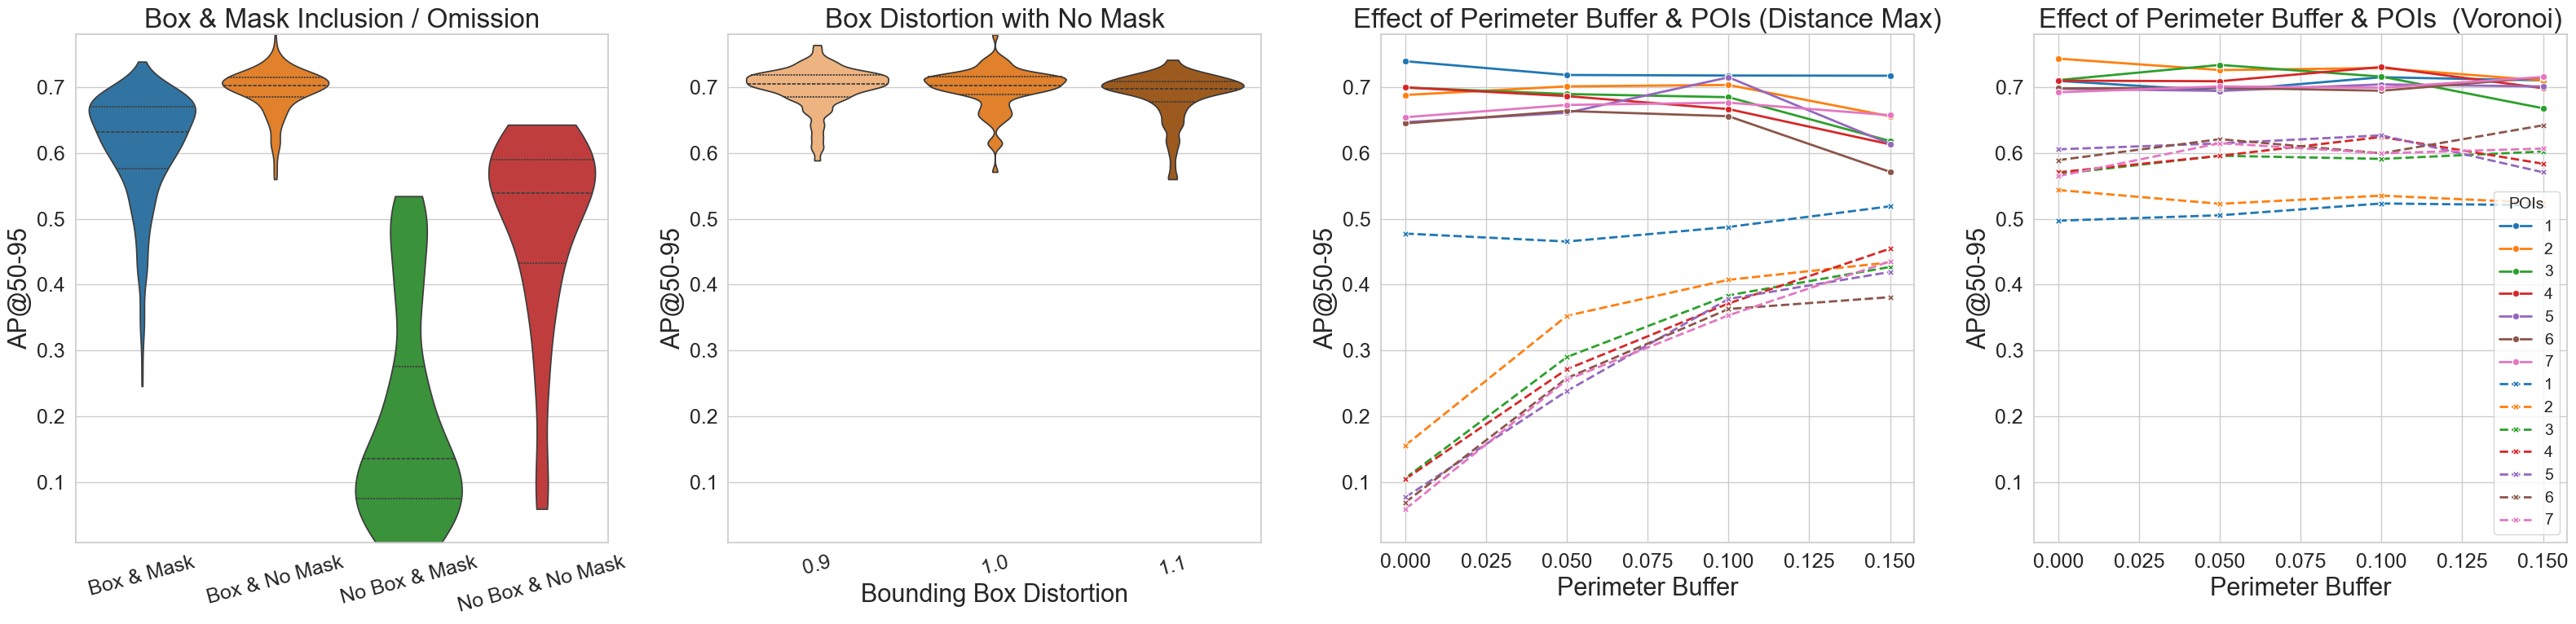

In [105]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Suppress specific warnings (optional)
import warnings
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Set global font size using seaborn's set_theme with a larger font_scale
sns.set_theme(style="whitegrid", font_scale=1.5)  # Adjust font_scale as needed

# Load data
file_path = "processedResults.csv"  # Update with the actual path if needed
data = pd.read_csv(file_path)

# Filter for YOLOv8 Nano and create a copy to avoid SettingWithCopyWarning
filtered_data = data[data['Model'] == 'YOLOv8 Nano'].copy()

# Ensure no negative values in avg_sam_mask_AP_50_95
filtered_data.loc[:, "avg_sam_mask_AP_50_95"] = filtered_data["avg_sam_mask_AP_50_95"].clip(lower=0)

# Convert percentage columns to numeric
filtered_data.loc[:, "BoundingBoxDistortion"] = (
    filtered_data["BoundingBoxDistortion"].astype(str).str.rstrip('%').astype(float) / 100
)
filtered_data.loc[:, "PerimeterBuffer"] = (
    filtered_data["PerimeterBuffer"].astype(str).str.rstrip('%').astype(float) / 100
)

# Define categories for the first plot
filtered_data.loc[:, "Category"] = filtered_data.apply(
    lambda row: "Box & Mask" if row["BoxInclusion"] and row["MaskInclusion"] else
                "Box & No Mask" if row["BoxInclusion"] and not row["MaskInclusion"] else
                "No Box & Mask" if not row["BoxInclusion"] and row["MaskInclusion"] else
                "No Box & No Mask", axis=1
)

# Prepare subsets for the second plot
filtered_subset1 = filtered_data[
    (filtered_data["BoxInclusion"] == True) & (filtered_data["MaskInclusion"] == False)
].copy()
filtered_subset1 = filtered_subset1[filtered_subset1["BoundingBoxDistortion"].isin([0.90, 1.00, 1.10])].copy()

# Calculate global min and max for avg_sam_mask_AP_50_95
all_data = pd.concat([
    filtered_data["avg_sam_mask_AP_50_95"], 
    filtered_subset1["avg_sam_mask_AP_50_95"]
])

global_min = all_data.min()
global_max = all_data.max()

# Define custom colors for the first plot (Categories)
category_palette = {
    "Box & Mask": "#1f77b4",  # Deep Blue
    "Box & No Mask": "#ff7f0e",  # Dark Orange
    "No Box & Mask": "#2ca02c",  # Forest Green
    "No Box & No Mask": "#d62728"  # Crimson Red
}

# Define custom colors for the second plot (Orange Variations)
base_orange = "#ff7f0e"
lighter_orange = mcolors.to_rgb(base_orange)  # Convert to RGB
lighter_orange = [(c + (1 - c) * 0.4) for c in lighter_orange]  # Lighten color (~40% toward white)
darker_orange = [(c * 0.7) for c in mcolors.to_rgb(base_orange)]  # Darken color (reduce brightness 30%)

# Create a figure with 4 subplots
fig, axes = plt.subplots(1, 4, figsize=(32, 8))  # Increased figure size for better readability

# -------------------
# Plot 1: Violin plot for avg_sam_mask_AP_50_95 by Category (Updated Colors)
# -------------------
sns.violinplot(
    x="Category", 
    y="avg_sam_mask_AP_50_95", 
    data=filtered_data, 
    hue="Category",  
    palette=category_palette,  
    inner="quartile", 
    cut=0, 
    density_norm="width",  
    ax=axes[0],
    legend=False  
)
axes[0].set_title("Box & Mask Inclusion / Omission", fontsize=24)
axes[0].set_xlabel("", fontsize=1)
axes[0].set_ylabel("AP@50-95", fontsize=22)
axes[0].tick_params(axis='x', rotation=15, labelsize=18)
axes[0].tick_params(axis='y', labelsize=18)
axes[0].set_ylim(global_min, global_max)

# -------------------
# Plot 2: Violin plot for BoundingBoxDistortion with Custom Orange Colors
# -------------------
sns.violinplot(
    x="BoundingBoxDistortion", 
    y="avg_sam_mask_AP_50_95", 
    data=filtered_subset1, 
    hue="BoundingBoxDistortion",  
    palette=[lighter_orange, base_orange, darker_orange],  
    inner="quartile", 
    cut=0, 
    bw_adjust=0.5, 
    density_norm="width",  
    ax=axes[1],
    legend=False  
)
axes[1].set_title("Box Distortion with No Mask", fontsize=24)
axes[1].set_xlabel("Bounding Box Distortion", fontsize=22)
axes[1].set_ylabel("AP@50-95", fontsize=22)
axes[1].tick_params(axis='x', rotation=15, labelsize=18)
axes[1].tick_params(axis='y', labelsize=18)
axes[1].set_ylim(global_min, global_max)



# -------------------
# Plot 3: Line plot for Distance Max (Solid and Dashed Lines)
# -------------------
sns.lineplot(
    data=solid_lines_dm, 
    x="PerimeterBuffer", 
    y="avg_sam_mask_AP_50_95", 
    hue="NumberOfPOIs", 
    marker="o", 
    palette="tab10", 
    linewidth=2, 
    errorbar=None,  # Updated from ci=None
    linestyle='solid', 
    ax=axes[2]
)
sns.lineplot(
    data=dashed_lines_dm, 
    x="PerimeterBuffer", 
    y="avg_sam_mask_AP_50_95", 
    hue="NumberOfPOIs", 
    marker="X", 
    palette="tab10", 
    linewidth=2, 
    errorbar=None,  # Updated from ci=None
    linestyle='dashed', 
    ax=axes[2]
)
axes[2].set_title("Effect of Perimeter Buffer & POIs (Distance Max)", fontsize=24)
axes[2].set_xlabel("Perimeter Buffer", fontsize=22)
axes[2].set_ylabel("AP@50-95", fontsize=22)
axes[2].tick_params(axis='x', labelsize=18)
axes[2].tick_params(axis='y', labelsize=18)
# axes[2].legend(title="Number of POIs", fontsize=14, title_fontsize=14)
axes[2].get_legend().remove()
axes[2].set_ylim(global_min, global_max)

# -------------------
# Plot 4: Line plot for Voronoi (Solid and Dashed Lines)
# -------------------
sns.lineplot(
    data=solid_lines_voronoi, 
    x="PerimeterBuffer", 
    y="avg_sam_mask_AP_50_95", 
    hue="NumberOfPOIs", 
    marker="o", 
    palette="tab10", 
    linewidth=2, 
    errorbar=None,  # Updated from ci=None
    linestyle='solid', 
    ax=axes[3]
)
sns.lineplot(
    data=dashed_lines_voronoi, 
    x="PerimeterBuffer", 
    y="avg_sam_mask_AP_50_95", 
    hue="NumberOfPOIs", 
    marker="X", 
    palette="tab10", 
    linewidth=2, 
    errorbar=None,  # Updated from ci=None
    linestyle='dashed', 
    ax=axes[3]
)
axes[3].set_title("Effect of Perimeter Buffer & POIs  (Voronoi)", fontsize=24)
axes[3].set_xlabel("Perimeter Buffer", fontsize=22)
axes[3].set_ylabel("AP@50-95", fontsize=22)
axes[3].tick_params(axis='x', labelsize=18)
axes[3].tick_params(axis='y', labelsize=18)
axes[3].legend(title="POIs", fontsize=14, title_fontsize=14, loc='lower right')
axes[3].set_ylim(global_min, global_max)

# Adjust layout for better spacing
plt.tight_layout()

# Optionally, save the figure with high resolution
# plt.savefig("updated_plots.png", dpi=300, bbox_inches='tight')

# Show plot
plt.show()


Plot 1 group counts:
Category
Box & Mask          84
Box & No Mask       84
No Box & Mask       84
No Box & No Mask    84
dtype: int64

Plot 2 group counts (by BoundingBoxDistortion):
BoundingBoxDistortion
0.9    84
1.0    84
1.1    84
dtype: int64


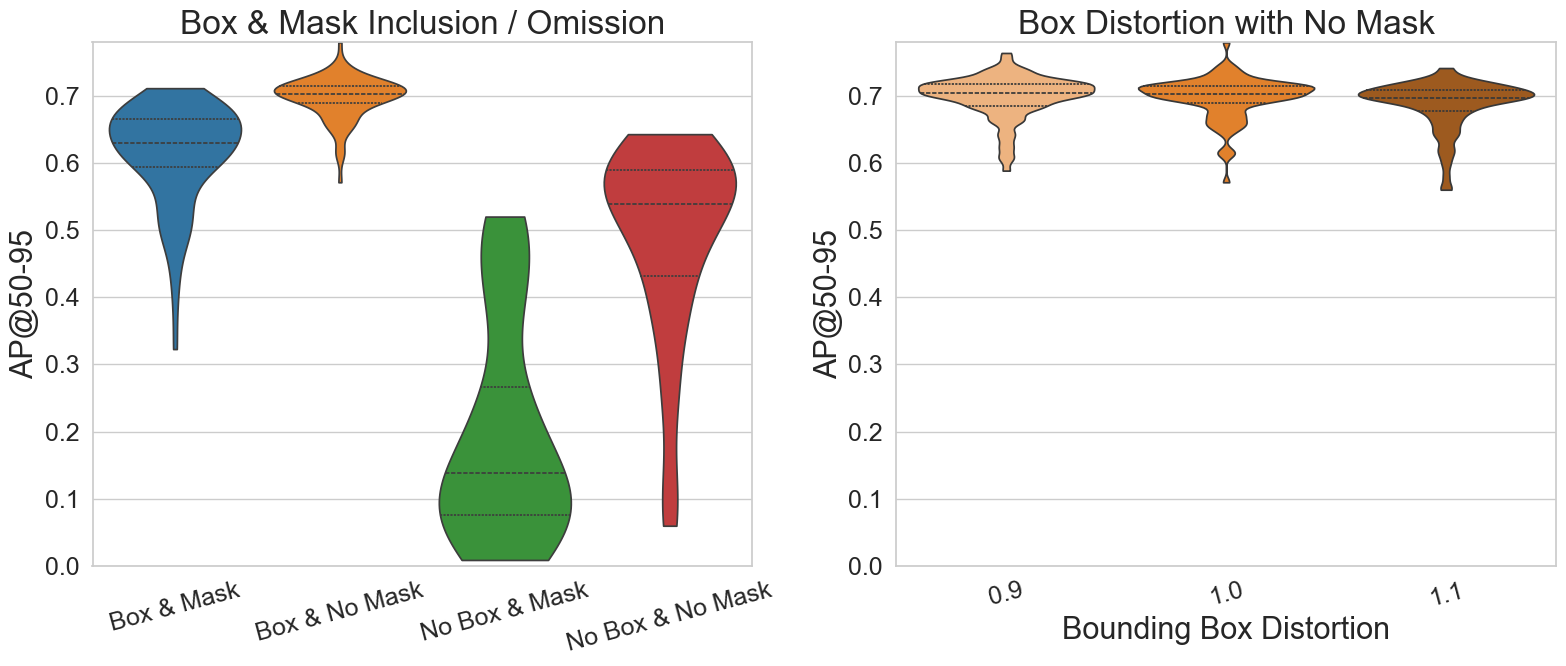

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import warnings

# Suppress specific warnings (optional)
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Set global style and font scale
sns.set_theme(style="whitegrid", font_scale=1.5)

# -------------------------------
# Load data and basic processing
# -------------------------------
file_path = "processedResults.csv"  # Update path if needed
data = pd.read_csv(file_path)

global_min = 0
global_max = data['avg_sam_mask_AP_50_95'].max()

# Filter for the YOLOv8 Nano + Sam model
nano_data = data[data['Model'] == 'YOLOv8 Nano'].copy()

# Ensure no negative values in avg_sam_mask_AP_50_95
nano_data.loc[:, "avg_sam_mask_AP_50_95"] = nano_data["avg_sam_mask_AP_50_95"].clip(lower=0)

# Convert percentage columns to numeric (assumes they are strings like "100%")
nano_data.loc[:, "BoundingBoxDistortion"] = (
    nano_data["BoundingBoxDistortion"].astype(str).str.rstrip('%').astype(float) / 100
)
nano_data.loc[:, "MaskDistortion"] = (
    nano_data["MaskDistortion"].astype(str).str.rstrip('%').astype(float) / 100
)
nano_data.loc[:, "PerimeterBuffer"] = (
    nano_data["PerimeterBuffer"].astype(str).str.rstrip('%').astype(float) / 100
)

# ---------------------------------------------------------------------------------------
# Prepare data for Plot 1:
# Only include rows that meet our specific grouping criteria:
# - If the bounding box is included (BoxInclusion == True), then its distortion must equal 1 (i.e. 100%).
#   Otherwise (BoxInclusion == False) we treat it as “NA”.
# - Similarly, if the mask is included (MaskInclusion == True) then its distortion must equal 1,
#   else it is “NA.”
# This will let us form the four desired groups.
# ---------------------------------------------------------------------------------------
plot1_data = nano_data[
    (
        (((nano_data["BoxInclusion"] == True) & (nano_data["BoundingBoxDistortion"] == 1))
         | (nano_data["BoxInclusion"] == False))
    ) &
    (
        (((nano_data["MaskInclusion"] == True) & (nano_data["MaskDistortion"] == 1))
         | (nano_data["MaskInclusion"] == False))
    )
].copy()

# Create a Category column with labels that match the keys in your palette.
def get_category(row):
    if row["BoxInclusion"] and row["MaskInclusion"]:
        return "Box & Mask"
    elif row["BoxInclusion"] and not row["MaskInclusion"]:
        return "Box & No Mask"
    elif not row["BoxInclusion"] and row["MaskInclusion"]:
        return "No Box & Mask"
    else:
        return "No Box & No Mask"

plot1_data["Category"] = plot1_data.apply(get_category, axis=1)

# (Optional) Print counts to verify the groups
print("Plot 1 group counts:")
print(plot1_data.groupby('Category').size())

# ---------------------------------------------------------
# Prepare data for Plot 2 (remains similar to your original)
# ---------------------------------------------------------
filtered_subset1 = nano_data[
    (nano_data["BoxInclusion"] == True) & (nano_data["MaskInclusion"] == False)
].copy()
filtered_subset1 = filtered_subset1[filtered_subset1["BoundingBoxDistortion"].isin([0.90, 1.00, 1.10])].copy()
print("\nPlot 2 group counts (by BoundingBoxDistortion):")
print(filtered_subset1.groupby('BoundingBoxDistortion').size())

# ----------------------------------------
# Define custom color palettes for the plots
# ----------------------------------------
category_palette = {
    "Box & Mask": "#1f77b4",       # Deep Blue
    "Box & No Mask": "#ff7f0e",   # Dark Orange
    "No Box & Mask": "#2ca02c",      # Forest Green
    "No Box & No Mask": "#d62728"    # Crimson Red
}

# For plot 2, define three shades of orange
base_orange = "#ff7f0e"
lighter_orange = mcolors.to_rgb(base_orange)
lighter_orange = [(c + (1 - c) * 0.4) for c in lighter_orange]  # ~40% lighter
darker_orange = [c * 0.7 for c in mcolors.to_rgb(base_orange)]     # ~30% darker

# -------------------------------
# Create the plots
# -------------------------------
fig, axes = plt.subplots(1, 2, figsize=(16, 7))  # Two subplots side-by-side

# Plot 1: Violin plot for avg_sam_mask_AP_50_95 by Category
sns.violinplot(
    x="Category",
    y="avg_sam_mask_AP_50_95",
    data=plot1_data,
    hue="Category",
    palette=category_palette,
    inner="quartile",
    cut=0,
    density_norm="width",
    ax=axes[0],
    legend=False
)
axes[0].set_title("Box & Mask Inclusion / Omission", fontsize=24)
axes[0].set_xlabel("", fontsize=1)
axes[0].set_ylabel("AP@50-95", fontsize=22)
axes[0].tick_params(axis='x', rotation=15, labelsize=18)
axes[0].tick_params(axis='y', labelsize=18)
axes[0].set_ylim(global_min, global_max)

# Plot 2: Violin plot for BoundingBoxDistortion with custom orange colors
sns.violinplot(
    x="BoundingBoxDistortion",
    y="avg_sam_mask_AP_50_95",
    data=filtered_subset1,
    hue="BoundingBoxDistortion",
    palette=[lighter_orange, base_orange, darker_orange],
    inner="quartile",
    cut=0,
    bw_adjust=0.5,
    density_norm="width",
    ax=axes[1],
    legend=False
)
axes[1].set_title("Box Distortion with No Mask", fontsize=24)
axes[1].set_xlabel("Bounding Box Distortion", fontsize=22)
axes[1].set_ylabel("AP@50-95", fontsize=22)
axes[1].tick_params(axis='x', rotation=15, labelsize=18)
axes[1].tick_params(axis='y', labelsize=18)
axes[1].set_ylim(global_min, global_max)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


Plot 1 group counts:
Category
Box & Mask          84
Box & No Mask       84
No Box & Mask       84
No Box & No Mask    84
dtype: int64

Plot 2 group counts (by BoundingBoxDistortion):
BoundingBoxDistortion
0.9    84
1.0    84
1.1    84
dtype: int64


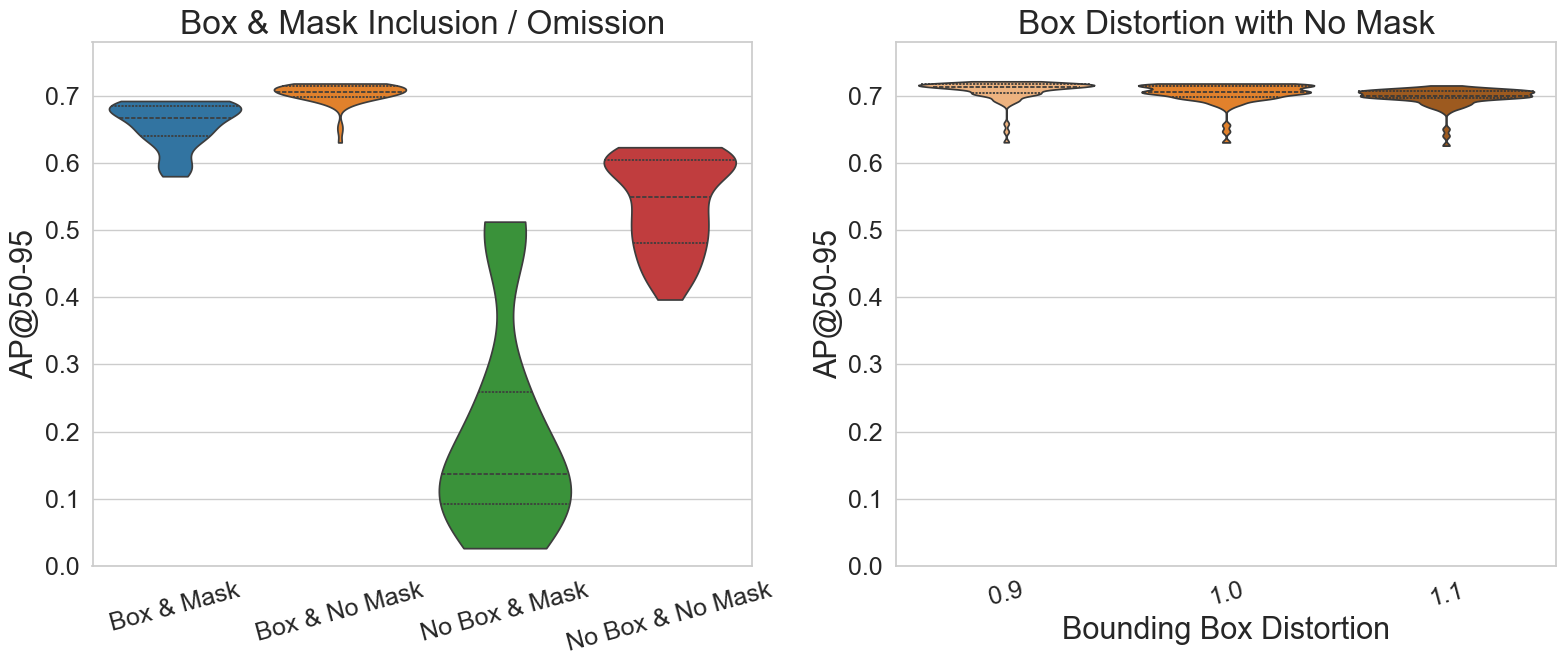

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import warnings

# Suppress specific warnings (optional)
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Set global style and font scale
sns.set_theme(style="whitegrid", font_scale=1.5)

# -------------------------------
# Load data and basic processing
# -------------------------------
file_path = "processedResults.csv"  # Update path if needed
data = pd.read_csv(file_path)

global_min = 0
global_max = data['avg_sam_mask_AP_50_95'].max()

# Filter for the YOLOv8 Nano + Sam model
nano_data = data[data['Model'] == 'YOLOv8 Nano + Sam'].copy()

# Ensure no negative values in avg_sam_mask_AP_50_95
nano_data.loc[:, "avg_sam_mask_AP_50_95"] = nano_data["avg_sam_mask_AP_50_95"].clip(lower=0)

# Convert percentage columns to numeric (assumes they are strings like "100%")
nano_data.loc[:, "BoundingBoxDistortion"] = (
    nano_data["BoundingBoxDistortion"].astype(str).str.rstrip('%').astype(float) / 100
)
nano_data.loc[:, "MaskDistortion"] = (
    nano_data["MaskDistortion"].astype(str).str.rstrip('%').astype(float) / 100
)
nano_data.loc[:, "PerimeterBuffer"] = (
    nano_data["PerimeterBuffer"].astype(str).str.rstrip('%').astype(float) / 100
)

# ---------------------------------------------------------------------------------------
# Prepare data for Plot 1:
# Only include rows that meet our specific grouping criteria:
# - If the bounding box is included (BoxInclusion == True), then its distortion must equal 1 (i.e. 100%).
#   Otherwise (BoxInclusion == False) we treat it as “NA”.
# - Similarly, if the mask is included (MaskInclusion == True) then its distortion must equal 1,
#   else it is “NA.”
# This will let us form the four desired groups.
# ---------------------------------------------------------------------------------------
plot1_data = nano_data[
    (
        (((nano_data["BoxInclusion"] == True) & (nano_data["BoundingBoxDistortion"] == 1))
         | (nano_data["BoxInclusion"] == False))
    ) &
    (
        (((nano_data["MaskInclusion"] == True) & (nano_data["MaskDistortion"] == 1))
         | (nano_data["MaskInclusion"] == False))
    )
].copy()

# Create a Category column with labels that match the keys in your palette.
def get_category(row):
    if row["BoxInclusion"] and row["MaskInclusion"]:
        return "Box & Mask"
    elif row["BoxInclusion"] and not row["MaskInclusion"]:
        return "Box & No Mask"
    elif not row["BoxInclusion"] and row["MaskInclusion"]:
        return "No Box & Mask"
    else:
        return "No Box & No Mask"

plot1_data["Category"] = plot1_data.apply(get_category, axis=1)

# (Optional) Print counts to verify the groups
print("Plot 1 group counts:")
print(plot1_data.groupby('Category').size())

# ---------------------------------------------------------
# Prepare data for Plot 2 (remains similar to your original)
# ---------------------------------------------------------
filtered_subset1 = nano_data[
    (nano_data["BoxInclusion"] == True) & (nano_data["MaskInclusion"] == False)
].copy()
filtered_subset1 = filtered_subset1[filtered_subset1["BoundingBoxDistortion"].isin([0.90, 1.00, 1.10])].copy()
print("\nPlot 2 group counts (by BoundingBoxDistortion):")
print(filtered_subset1.groupby('BoundingBoxDistortion').size())

# ----------------------------------------
# Define custom color palettes for the plots
# ----------------------------------------
category_palette = {
    "Box & Mask": "#1f77b4",       # Deep Blue
    "Box & No Mask": "#ff7f0e",   # Dark Orange
    "No Box & Mask": "#2ca02c",      # Forest Green
    "No Box & No Mask": "#d62728"    # Crimson Red
}

# For plot 2, define three shades of orange
base_orange = "#ff7f0e"
lighter_orange = mcolors.to_rgb(base_orange)
lighter_orange = [(c + (1 - c) * 0.4) for c in lighter_orange]  # ~40% lighter
darker_orange = [c * 0.7 for c in mcolors.to_rgb(base_orange)]     # ~30% darker

# -------------------------------
# Create the plots
# -------------------------------
fig, axes = plt.subplots(1, 2, figsize=(16, 7))  # Two subplots side-by-side

# Plot 1: Violin plot for avg_sam_mask_AP_50_95 by Category
sns.violinplot(
    x="Category",
    y="avg_sam_mask_AP_50_95",
    data=plot1_data,
    hue="Category",
    palette=category_palette,
    inner="quartile",
    cut=0,
    density_norm="width",
    ax=axes[0],
    legend=False
)
axes[0].set_title("Box & Mask Inclusion / Omission", fontsize=24)
axes[0].set_xlabel("", fontsize=1)
axes[0].set_ylabel("AP@50-95", fontsize=22)
axes[0].tick_params(axis='x', rotation=15, labelsize=18)
axes[0].tick_params(axis='y', labelsize=18)
axes[0].set_ylim(global_min, global_max)

# Plot 2: Violin plot for BoundingBoxDistortion with custom orange colors
sns.violinplot(
    x="BoundingBoxDistortion",
    y="avg_sam_mask_AP_50_95",
    data=filtered_subset1,
    hue="BoundingBoxDistortion",
    palette=[lighter_orange, base_orange, darker_orange],
    inner="quartile",
    cut=0,
    bw_adjust=0.5,
    density_norm="width",
    ax=axes[1],
    legend=False
)
axes[1].set_title("Box Distortion with No Mask", fontsize=24)
axes[1].set_xlabel("Bounding Box Distortion", fontsize=22)
axes[1].set_ylabel("AP@50-95", fontsize=22)
axes[1].tick_params(axis='x', rotation=15, labelsize=18)
axes[1].tick_params(axis='y', labelsize=18)
axes[1].set_ylim(global_min, global_max)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


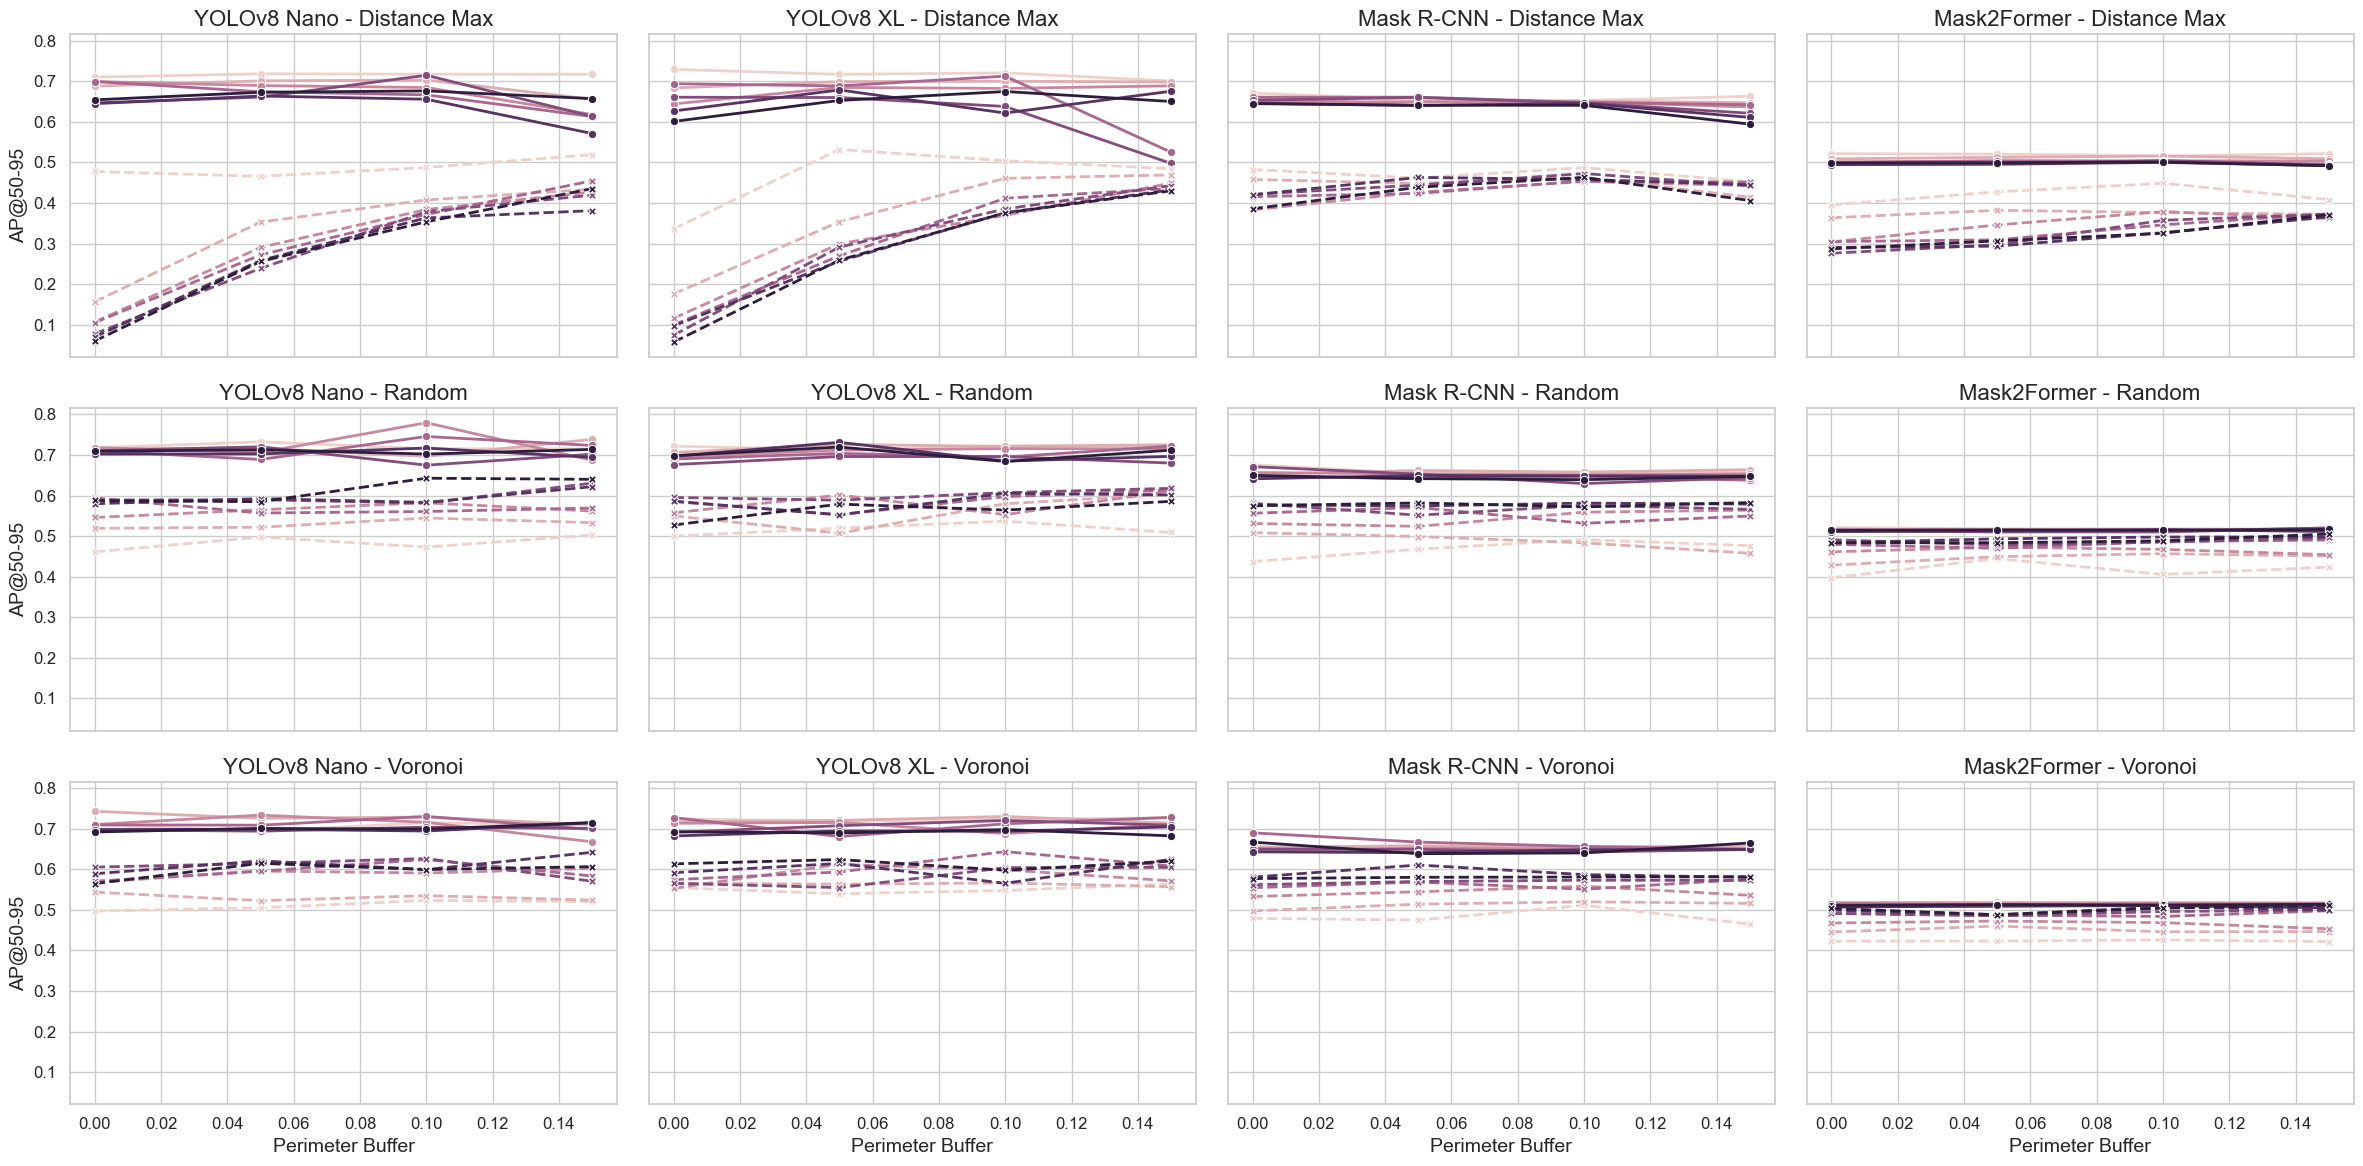

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
file_path = "processedResults.csv"  # Update with the actual path if needed
data = pd.read_csv(file_path)

# Ensure no negative values in sam_mask_AP@50:95
data["avg_sam_mask_AP_50_95"] = data["avg_sam_mask_AP_50_95"].clip(lower=0)

# Convert percentage columns to numeric
# Convert PerimeterBuffer from a percentage string (e.g. "10%") to a fraction (e.g. 0.10)
data["PerimeterBuffer"] = data["PerimeterBuffer"].astype(str).str.rstrip('%').astype(float) / 100
# Convert BoundingBoxDistortion from a percentage string (e.g. "100%") to a fraction (e.g. 1.0)
data["BoundingBoxDistortion"] = data["BoundingBoxDistortion"].astype(str).str.rstrip('%').astype(float) / 100

# Filter out rows where MaskInclusion is True and exclude rows where BoundingBoxDistortion is 90% or 110%
data = data[(data["MaskInclusion"] == False) & (~data["BoundingBoxDistortion"].isin([0.9, 1.1]))]

# Create a 3x3 grid: rows for Models, columns for Segmentation Methods
fig, axes = plt.subplots(3, 4, figsize=(24, 12), sharex=True, sharey=True)
model_list = ['YOLOv8 Nano', 'YOLOv8 XL', 'Mask R-CNN', 'Mask2Former']
method_list = ['Distance Max', 'Random', 'Voronoi']

# Loop over each combination of Model (rows) and Segmentation Method (columns)
for i, model in enumerate(model_list):
    for j, method in enumerate(method_list):
        ax = axes[j, i]
        
        # Filter data for the current model and segmentation method (POIPlacementAlgorithm)
        subset = data[(data['Model'] == model) & (data['POIPlacementAlgorithm'] == method)]
        
        # Separate data based on BoxInclusion: solid if True, dashed if False
        subset_solid = subset[subset['BoxInclusion'] == True]
        subset_dashed = subset[subset['BoxInclusion'] == False]
        
        # Plot the solid lines (with circular markers) for BoxInclusion == True
        sns.lineplot(
            data=subset_solid,
            x="PerimeterBuffer",
            y="avg_sam_mask_AP_50_95",
            hue="NumberOfPOIs",
            marker="o",
            linewidth=2,
            linestyle='solid',
            ax=ax,
            legend=False  # Legend can be added later as needed
        )
        
        # Plot the dashed lines (with X markers) for BoxInclusion == False
        sns.lineplot(
            data=subset_dashed,
            x="PerimeterBuffer",
            y="avg_sam_mask_AP_50_95",
            hue="NumberOfPOIs",
            marker="X",
            linewidth=2,
            linestyle='dashed',
            ax=ax,
            legend=False
        )
        
        # Set the title for the subplot to indicate model and method
        ax.set_title(f"{model} - {method}", fontsize=16)
        ax.set_xlabel("Perimeter Buffer", fontsize=14)
        ax.set_ylabel("AP@50-95", fontsize=14)
        ax.tick_params(axis='both', labelsize=12)

# Adjust layout for better spacing between subplots
plt.tight_layout()

# Optionally, save the figure
# plt.savefig("3x3_grid_plots.png", dpi=300, bbox_inches='tight')

plt.show()


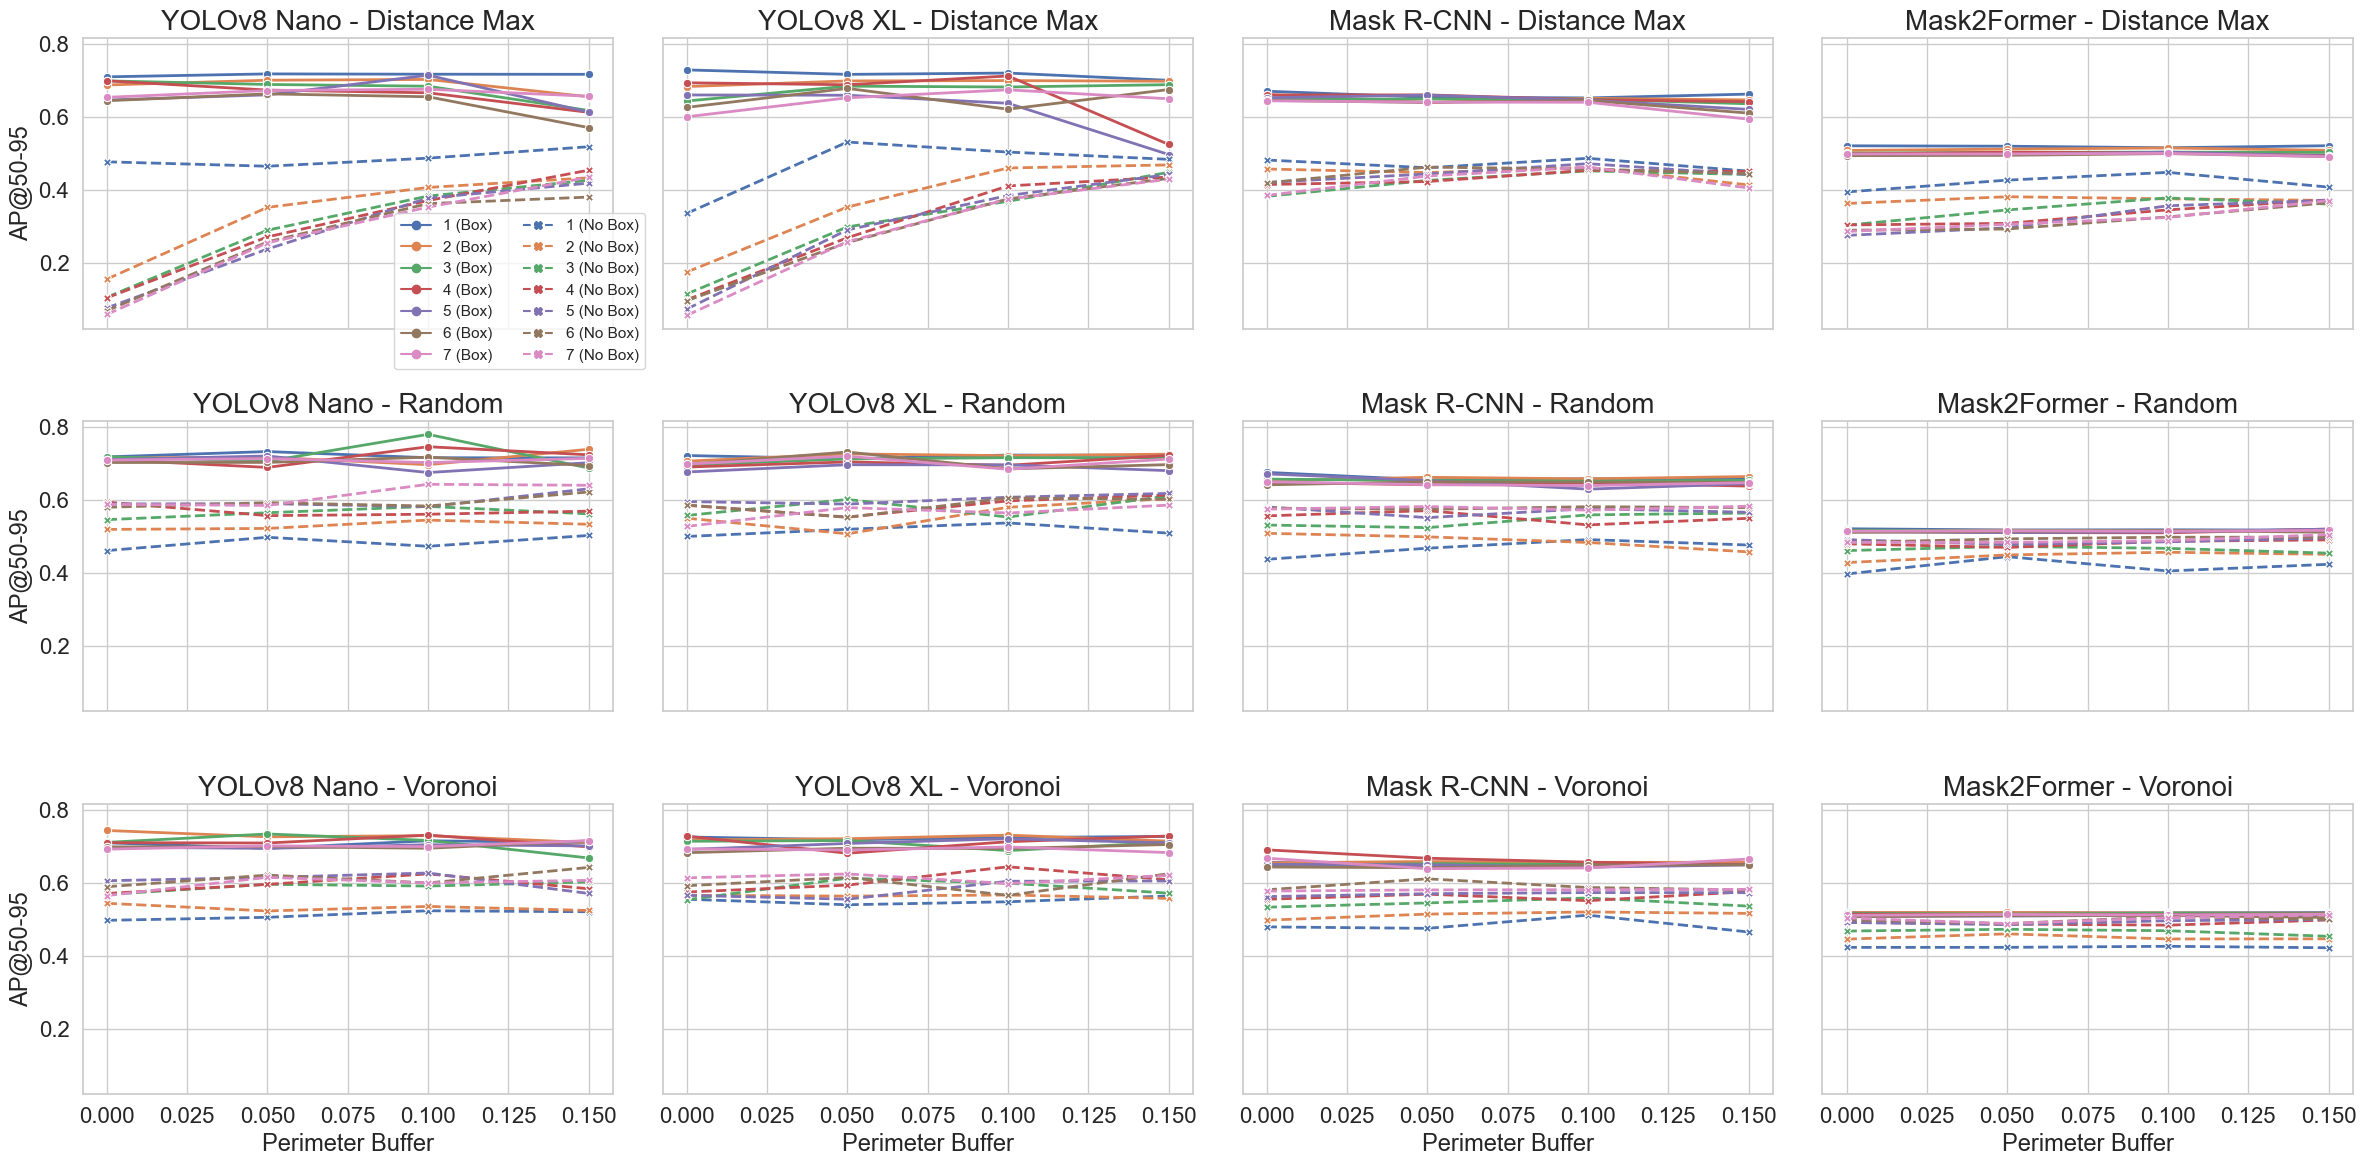

In [69]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# Load data
file_path = "processedResults.csv"  # Update with the actual path if needed
data = pd.read_csv(file_path)

# Ensure no negative values in avg_sam_mask_AP_50_95
data["avg_sam_mask_AP_50_95"] = data["avg_sam_mask_AP_50_95"].clip(lower=0)

# Convert percentage strings to numeric fractions
data["PerimeterBuffer"] = data["PerimeterBuffer"].astype(str).str.rstrip('%').astype(float) / 100
data["BoundingBoxDistortion"] = data["BoundingBoxDistortion"].astype(str).str.rstrip('%').astype(float) / 100

# Filter out rows:
#  - Only include rows where MaskInclusion is False
#  - Exclude rows where BoundingBoxDistortion is 90% or 110%
data = data[(data["MaskInclusion"] == False) & (~data["BoundingBoxDistortion"].isin([0.9, 1.1]))]

# Build a global color palette based on all unique NumberOfPOIs in the dataset.
unique_all = sorted(data['NumberOfPOIs'].unique())
color_palette = sns.color_palette("deep", n_colors=len(unique_all))
color_dict = dict(zip(unique_all, color_palette))

# Create a 3x4 grid:
# - Columns correspond to Models (from model_list)
# - Rows correspond to Segmentation Methods (from method_list)
fig, axes = plt.subplots(3, 4, figsize=(24, 12), sharex=True, sharey=True)
model_list = ['YOLOv8 Nano', 'YOLOv8 XL', 'Mask R-CNN', 'Mask2Former']
method_list = ['Distance Max', 'Random', 'Voronoi']

for i, model in enumerate(model_list):
    for j, method in enumerate(method_list):
        ax = axes[j, i]
        
        # Filter data for the current model and segmentation method
        subset = data[(data['Model'] == model) & (data['POIPlacementAlgorithm'] == method)]
        
        # Separate based on BoxInclusion:
        subset_solid = subset[subset['BoxInclusion'] == True]   # Box (solid)
        subset_dashed = subset[subset['BoxInclusion'] == False]  # No Box (dashed)
        
        # Plot solid lines (with circular markers) for BoxInclusion==True.
        sns.lineplot(
            data=subset_solid,
            x="PerimeterBuffer",
            y="avg_sam_mask_AP_50_95",
            hue="NumberOfPOIs",
            marker="o",
            linewidth=2,
            linestyle='solid',
            ax=ax,
            palette=color_dict,
            legend=False  # We'll create a custom legend later for one subplot.
        )
        
        # Plot dashed lines (with X markers) for BoxInclusion==False.
        sns.lineplot(
            data=subset_dashed,
            x="PerimeterBuffer",
            y="avg_sam_mask_AP_50_95",
            hue="NumberOfPOIs",
            marker="X",
            linewidth=2,
            linestyle='dashed',
            ax=ax,
            palette=color_dict,
            legend=False
        )
        
        # Set title and axis labels
        ax.set_title(f"{model} - {method}", fontsize=20)
        ax.set_xlabel("Perimeter Buffer", fontsize=17)
        ax.set_ylabel("AP@50-95", fontsize=17)
        ax.tick_params(axis='both', labelsize=16)
        
        # In the top-left subplot (first column, first row) add a custom legend.
        # This legend will display:
        #  - Left column: the solid-line ("Box") handles.
        #  - Right column: the dashed-line ("No Box") handles.
        # And it will be placed in the bottom right of the axis.
        if i == 0 and j == 0:
            # Get the union of POI numbers present in this subplot.
            unique_hues = sorted(
                set(subset_solid['NumberOfPOIs'].unique()).union(set(subset_dashed['NumberOfPOIs'].unique()))
            )
            # Build separate lists for Box and No Box legend handles.
            box_handles = []
            no_box_handles = []
            # Use a smaller marker size for the legend
            small_marker_size = 6
            for val in unique_hues:
                color = color_dict[val]
                handle_box = mlines.Line2D(
                    [], [], color=color, marker='o', linestyle='solid',
                    markersize=small_marker_size, label=f"{val} (Box)"
                )
                handle_no_box = mlines.Line2D(
                    [], [], color=color, marker='X', linestyle='dashed',
                    markersize=small_marker_size, label=f"{val} (No Box)"
                )
                box_handles.append(handle_box)
                no_box_handles.append(handle_no_box)
            
            # Instead of interleaving the handles, simply concatenate them.
            # With ncol=2, Matplotlib will place the first half (Box handles) in the left column
            # and the second half (No Box handles) in the right column.
            legend_handles = box_handles + no_box_handles
            
            # Place the legend in the bottom right of the axis and reduce font sizes.
            ax.legend(
                handles=legend_handles,
                loc='lower right',           
                bbox_to_anchor=(1.075, -0.165),  # moved a bit further right and lower
                ncol=2,                        
                # title="POIs",
                fontsize=11,
                title_fontsize=10
            )


plt.tight_layout()
plt.show()


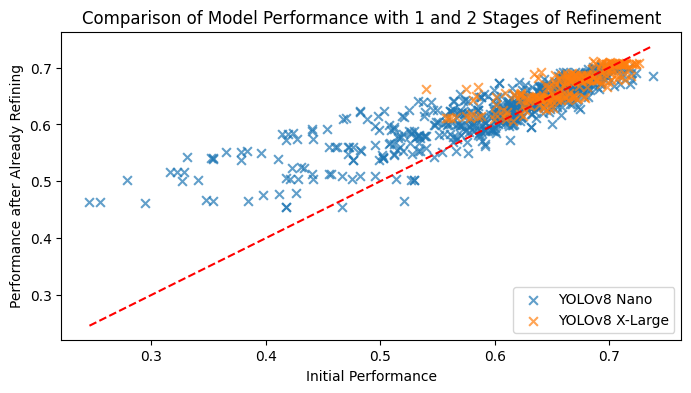

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = "processedResults.csv"  # Replace with your actual file path
df = pd.read_csv(file_path)

# Identify pairs of rows with identical criteria
columns_to_match = [
    "BoxInclusion", "MaskInclusion", "NumberOfPOIs", 
    "POIPlacementAlgorithm", "PerimeterBuffer", 
    "BoundingBoxDistortion", "MaskDistortion"
]

paired_rows = []
models_with_sam = {}

# Organize rows by matching criteria
grouped = df.groupby(columns_to_match)

for _, group in grouped:
    model_dict = {}
    # First, separate rows with and without "+ Sam"
    for _, row in group.iterrows():
        model_name = row["Model"]
        if " + Sam" in model_name:
            # Remove " + Sam" to obtain the base model name.
            base_model = model_name.replace(" + Sam", "")
            models_with_sam[base_model] = row
        else:
            model_dict[model_name] = row

    # If a pair is found (i.e. both without and with "+ Sam"), store it.
    for base_model, base_row in model_dict.items():
        if base_model in models_with_sam:
            sam_row = models_with_sam[base_model]
            paired_rows.append((base_row, sam_row))

# Plot results, using a different color for each base model.
if paired_rows:
    # Group pairs by base model name.
    pairs_by_model = {}
    for base_row, sam_row in paired_rows:
        base_model = base_row["Model"]
        if base_model not in pairs_by_model:
            pairs_by_model[base_model] = {"x": [], "y": []}
        pairs_by_model[base_model]["x"].append(base_row["avg_sam_mask_AP_50_95"])
        pairs_by_model[base_model]["y"].append(sam_row["avg_sam_mask_AP_50_95"])

    plt.figure(figsize=(8, 4))
    
    # Compute global min and max for the diagonal line.
    all_x = [val for d in pairs_by_model.values() for val in d["x"]]
    min_val = min(all_x)
    max_val = max(all_x)
    
    # Use the default color cycle from matplotlib.
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for idx, (model, data) in enumerate(pairs_by_model.items()):
        color = colors[idx % len(colors)]
        plt.scatter(data["x"], data["y"], marker="x", s=40, color=color, alpha=0.7, label=model)
    
    # Plot a diagonal reference line.
    plt.plot([min_val, max_val], [min_val, max_val], linestyle="--", color="red")
    plt.xlabel("Initial Performance")
    plt.ylabel("Performance after Already Refining")
    plt.title("Comparison of Model Performance with 1 and 2 Stages of Refinement")
    plt.legend(loc="lower right")
    plt.show()
else:
    print("No matching model pairs found.")
